**Introducción:**

En el año 2015 Nepal fue afectado por el terremoto Gorkha, un sismo que registró una
magnitud de 7.8 en la escala Richter y tuvo su epicentro en la ciudad de Kathmandu.
Aproximadamente 600,000 estructuras en el centro y pueblos aledaños fueron dañadas o
destruidas. Un análisis posterior al sismo llevado por la Comisión Nacional de
Planeamiento de Nepal comunicó que la pérdida total económica ocasionada por el
terremoto fue de aproximadamente $7 mil millones (USD; NPC, 2015).
El dataset para el presente TP está compuesto de encuestas realizadas por Kathmandu
Living Labs y el Central Bureau of Statistics y contiene información sobre el impacto del
terremoto, estado de viviendas y estadísticas sociodemográficas.
Particularmente el dataset se enfoca en cómo eran las condiciones de una determinada
vivienda y cuál fue su grado de daño luego del accidente.

In [423]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [424]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [425]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [426]:
#Datos en https://www.drivendata.org/competitions/57/nepal-earthquake/data/
id='1Aj5sniiRHdXWetPNF6d36eMOREohvhNE'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_labels.csv')
train_labels = pd.read_csv('train_labels.csv')

In [427]:
id='19F4CRGMIuqQqcQ0zow0gvQcnelV7PQrH'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')
train_values = pd.read_csv('train_values.csv')


In [428]:
train_labels.shape


(260601, 2)

In [429]:
train_values.shape

(260601, 39)

In [430]:
earthquakes = pd.merge(train_values, train_labels, how="inner", on="building_id")
earthquakes.head()

building_id  geo_level_1_id  ...  has_secondary_use_other  damage_grade
0       802906               6  ...                        0             3
1        28830               8  ...                        0             2
2        94947              21  ...                        0             3
3       590882              22  ...                        0             2
4       201944              11  ...                        0             3

[5 rows x 40 columns]

In [431]:
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [432]:
earthquakes.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

In [433]:
earthquakes.describe()

building_id  ...         damage_grade
count           260,601.00  ...           260,601.00
mean            525,675.48  ...                 2.24
std             304,545.00  ...                 0.61
min                   4.00  ...                 1.00
25%             261,190.00  ...                 2.00
50%             525,757.00  ...                 2.00
75%             789,762.00  ...                 3.00
max           1,052,934.00  ...                 3.00

[8 rows x 32 columns]

In [434]:
# antes de eliminar geo levels 2 y 3, nos fijamos cómo se distribuyen en geo level 1

earthquakes_by_geolevel1 = earthquakes.loc[:,['geo_level_1_id','geo_level_2_id','geo_level_3_id']].groupby('geo_level_1_id').nunique().reset_index(inplace=False)
earthquakes_by_geolevel1

geo_level_1_id  geo_level_2_id  geo_level_3_id
0                0              57             472
1                1              47             359
2                2              54             257
3                3               6              92
4                4              55             495
5                5              62             462
6                6              90             816
7                7              67             603
8                8              62             560
9                9              16             191
10              10              50             450
11              11              26             277
12              12              73             602
13              13              56             503
14              14              76             455
15              15              56             433
16              16              31             277
17              17              79             711
18              18              18             160
19              19              36             144
20              20              54             494
21              21              52             471
22              22              42             387
23              23              30             217
24              24              26             190
25              25              40             357
26              26              44             398
27              27              11             208
28              28              29             101
29              29              35             158
30              30              34             295

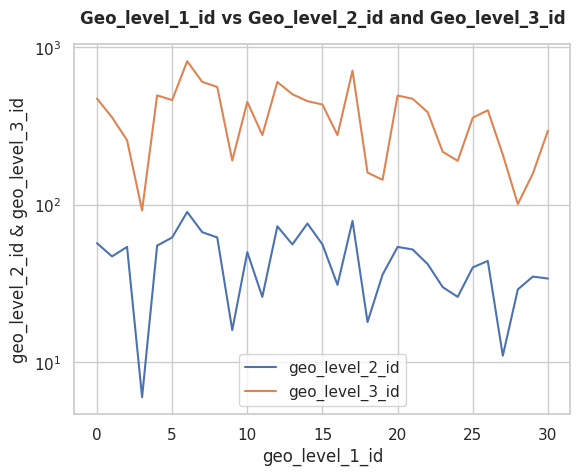

In [435]:
# a partir del siguiente gráfico, podemos ver la distribución de los geo_level_2_id y geo_level_3_id  con respecto al geo_level_1_id 
# concluimos que poseen un comportamiento similar entre sí y que ninguno supera un orden de magnitud
# motivo por lo cual consideramos que no aportan información al análisis exploratorio de datos adicional a la que ya aporta geo_level_1_id 
earthquakes_by_geolevel1.iloc[:,[1,2]].plot(kind='line',logy=True, legend=True, )
plt.xlabel('geo_level_1_id') 
plt.ylabel('geo_level_2_id & geo_level_3_id') 
plt.title("Geo_level_1_id vs Geo_level_2_id and Geo_level_3_id", pad='15.0', fontweight='bold')
plt.show() 

In [436]:
earthquakes = earthquakes.drop(columns = ['building_id', 'geo_level_2_id', 'geo_level_3_id']) 

In [437]:
earthquakes = earthquakes.astype({
                    'geo_level_1_id': 'int8', \
                    'count_floors_pre_eq': 'int8', \
                    'age': 'int16', \
                    'area_percentage': 'int8', \
                    'height_percentage': 'int8', \
                    'count_families': 'int8', \
                    'land_surface_condition': 'category', \
                    'foundation_type': 'category', \
                    'roof_type': 'category', \
                    'ground_floor_type': 'category', \
                    'other_floor_type': 'category', \
                    'position': 'category', \
                    'plan_configuration': 'category', \
                    'legal_ownership_status': 'category', \
                    'damage_grade': 'int8', \
                    'has_superstructure_adobe_mud': 'bool', \
                    'has_superstructure_mud_mortar_stone': 'bool', \
                    'has_superstructure_stone_flag': 'bool', \
                    'has_superstructure_cement_mortar_stone': 'bool', \
                    'has_superstructure_mud_mortar_brick': 'bool', \
                    'has_superstructure_cement_mortar_brick': 'bool', \
                    'has_superstructure_timber': 'bool', \
                    'has_superstructure_bamboo': 'bool', \
                    'has_superstructure_rc_non_engineered': 'bool', \
                    'has_superstructure_rc_engineered': 'bool', \
                    'has_superstructure_other': 'bool', \
                    'has_secondary_use': 'bool', \
                    'has_secondary_use_agriculture': 'bool', \
                    'has_secondary_use_hotel': 'bool', \
                    'has_secondary_use_rental': 'bool', \
                    'has_secondary_use_institution': 'bool', \
                    'has_secondary_use_school': 'bool', \
                    'has_secondary_use_industry': 'bool', \
                    'has_secondary_use_health_post': 'bool', \
                    'has_secondary_use_gov_office': 'bool', \
                    'has_secondary_use_use_police': 'bool', \
                    'has_secondary_use_other': 'bool'\
                    })

In [438]:
earthquakes.dtypes

geo_level_1_id                                int8
count_floors_pre_eq                           int8
age                                          int16
area_percentage                               int8
height_percentage                             int8
land_surface_condition                    category
foundation_type                           category
roof_type                                 category
ground_floor_type                         category
other_floor_type                          category
position                                  category
plan_configuration                        category
has_superstructure_adobe_mud                  bool
has_superstructure_mud_mortar_stone           bool
has_superstructure_stone_flag                 bool
has_superstructure_cement_mortar_stone        bool
has_superstructure_mud_mortar_brick           bool
has_superstructure_cement_mortar_brick        bool
has_superstructure_timber                     bool
has_superstructure_bamboo      

In [439]:
earthquakes.head()

geo_level_1_id  count_floors_pre_eq  ...  has_secondary_use_other  damage_grade
0               6                    2  ...                    False             3
1               8                    2  ...                    False             2
2              21                    2  ...                    False             3
3              22                    2  ...                    False             2
4              11                    3  ...                    False             3

[5 rows x 37 columns]

In [440]:
earthquakes.describe()

geo_level_1_id  ...         damage_grade
count           260,601.00  ...           260,601.00
mean                 13.90  ...                 2.24
std                   8.03  ...                 0.61
min                   0.00  ...                 1.00
25%                   7.00  ...                 2.00
50%                  12.00  ...                 2.00
75%                  21.00  ...                 3.00
max                  30.00  ...                 3.00

[8 rows x 7 columns]

In [441]:
#cantidad de terremotos en base al damage_grade
earthquakes_dg1 = earthquakes[earthquakes.damage_grade == 1].count()['damage_grade']
earthquakes_dg2 = earthquakes[earthquakes.damage_grade == 2].count()['damage_grade']
earthquakes_dg3 = earthquakes[earthquakes.damage_grade == 3].count()['damage_grade']  

total_dg = earthquakes_dg1 + earthquakes_dg2 + earthquakes_dg3
percentage_dg1 = round((earthquakes_dg1 * 100)/total_dg,2)
percentage_dg2 = round((earthquakes_dg2 * 100)/total_dg,2)
percentage_dg3 = round((earthquakes_dg3 * 100)/total_dg,2)

print('earthquakes with damage_grade = 1: ' + str(earthquakes_dg1) + ' = ' + str(percentage_dg1) + '%')
print('earthquakes with damage_grade = 2: ' + str(earthquakes_dg2) + ' = ' + str(percentage_dg2) + '%')
print('earthquakes with damage_grade = 3: ' + str(earthquakes_dg3) + ' = ' + str(percentage_dg3) + '%')

earthquakes with damage_grade = 1: 25124 = 9.64%
earthquakes with damage_grade = 2: 148259 = 56.89%
earthquakes with damage_grade = 3: 87218 = 33.47%


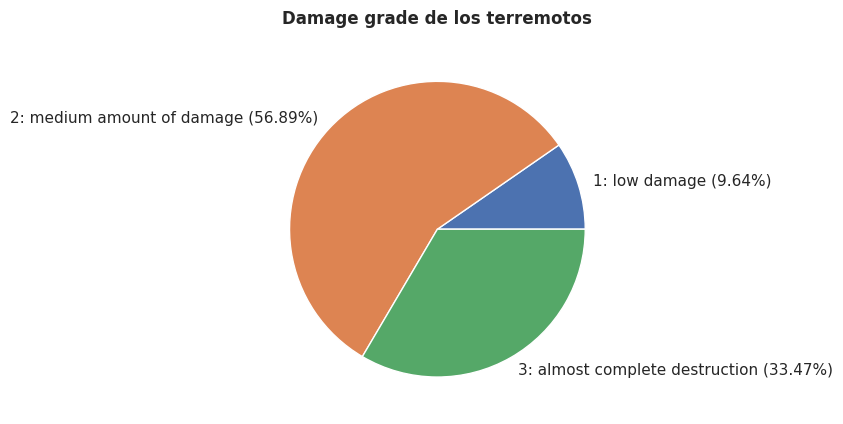

In [442]:
percentage_damage_grade = np.array([percentage_dg1, percentage_dg2, percentage_dg3])
labels = ['1: low damage (' + str(percentage_dg1) + '%)', \
          '2: medium amount of damage (' + str(percentage_dg2) + '%)',\
          '3: almost complete destruction (' + str(percentage_dg3) + '%)']

plt.pie(percentage_damage_grade, labels = labels)
plt.title("Damage grade de los terremotos", pad='15.0', fontweight='bold')
plt.show() 

Text(0.5, 1.05, 'Relación entre height_percentage y count_floors_pre_eq')

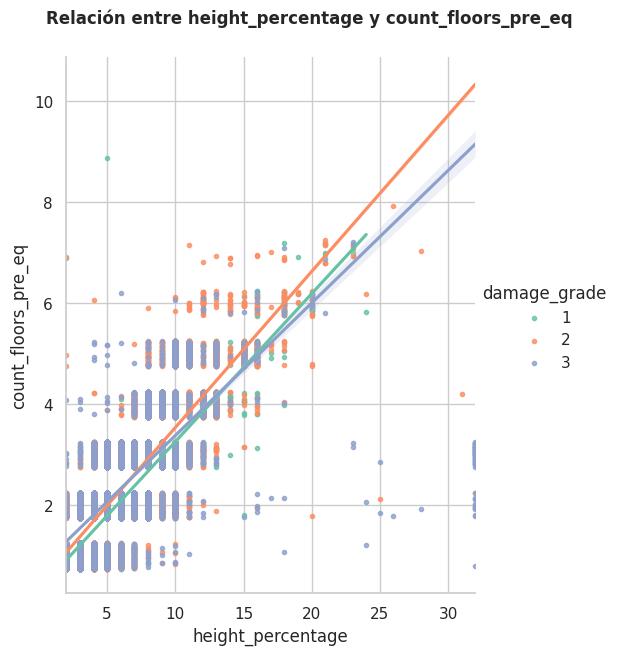

In [443]:
#se genera una copia de la base unificada para futuros filtros
# luego se realiza un gráfico de dispersion entre la cantidad de pisos y
# el porcentaje de altura para compararlas, a su vez esto para cada damage_grade
# y comparar sus correlaciones (se le aplicó un poco de fluctuación a los datos)

earthquakes2=earthquakes
lm = sns.lmplot(data=earthquakes, y='count_floors_pre_eq', x='height_percentage'\
          ,fit_reg=True, hue='damage_grade', legend=True, size=6,markers='.'\
          ,palette='Set2',aspect=.8,y_jitter=0.25,x_jitter=0.0,legend_out=True)
fig = lm.fig 
fig.suptitle("Relación entre height_percentage y count_floors_pre_eq", fontsize=12, fontweight='bold', y=1.05)

Text(0.5, 1.05, 'height_percentage vs area_percentage analizado por separado en base al damaga_grade')

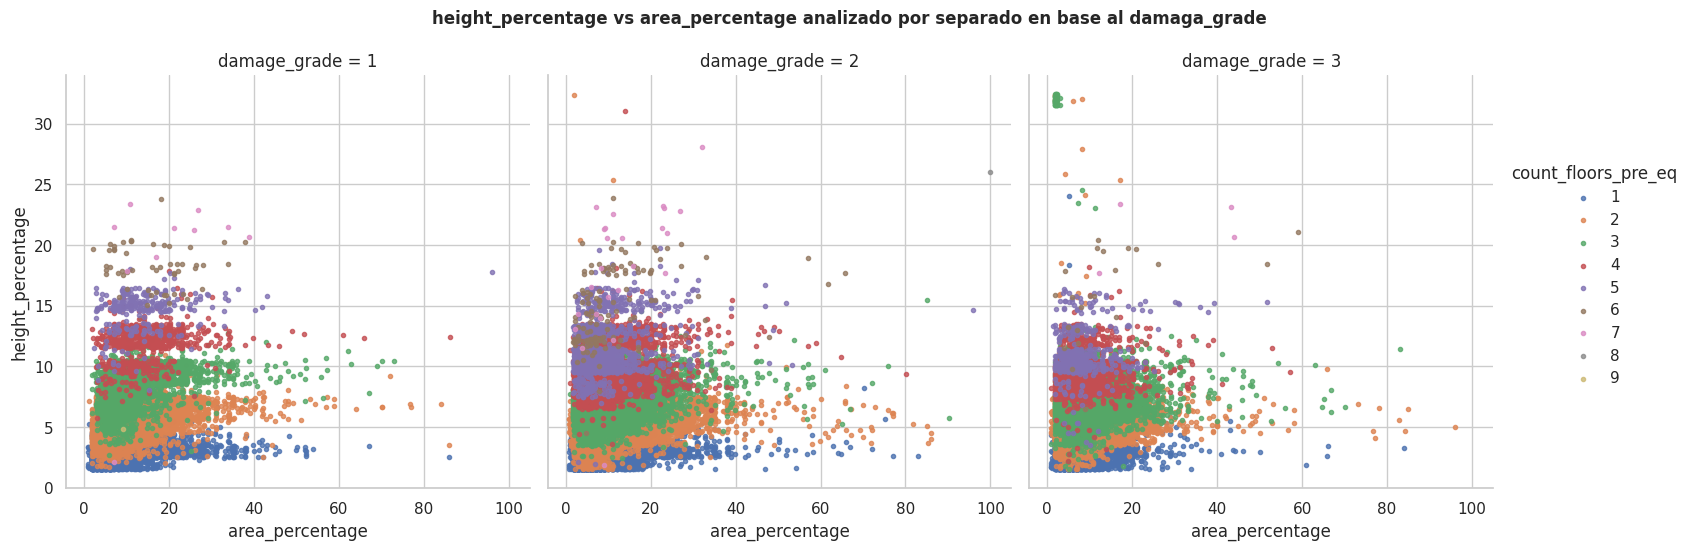

In [444]:
# una variante del grafico anterior para sumar, puede ser uno igual pero por cada damage, donde se categoriza por color los pisos.

lm = sns.lmplot(data=earthquakes, x='area_percentage', y='height_percentage', markers='.'\
           ,y_jitter=0.5,x_jitter=0.25,fit_reg=False\
           ,hue='count_floors_pre_eq',col_wrap=3,col='damage_grade')
fig = lm.fig 
fig.suptitle("height_percentage vs area_percentage analizado por separado en base al damaga_grade", fontsize=12, fontweight='bold', y=1.05)

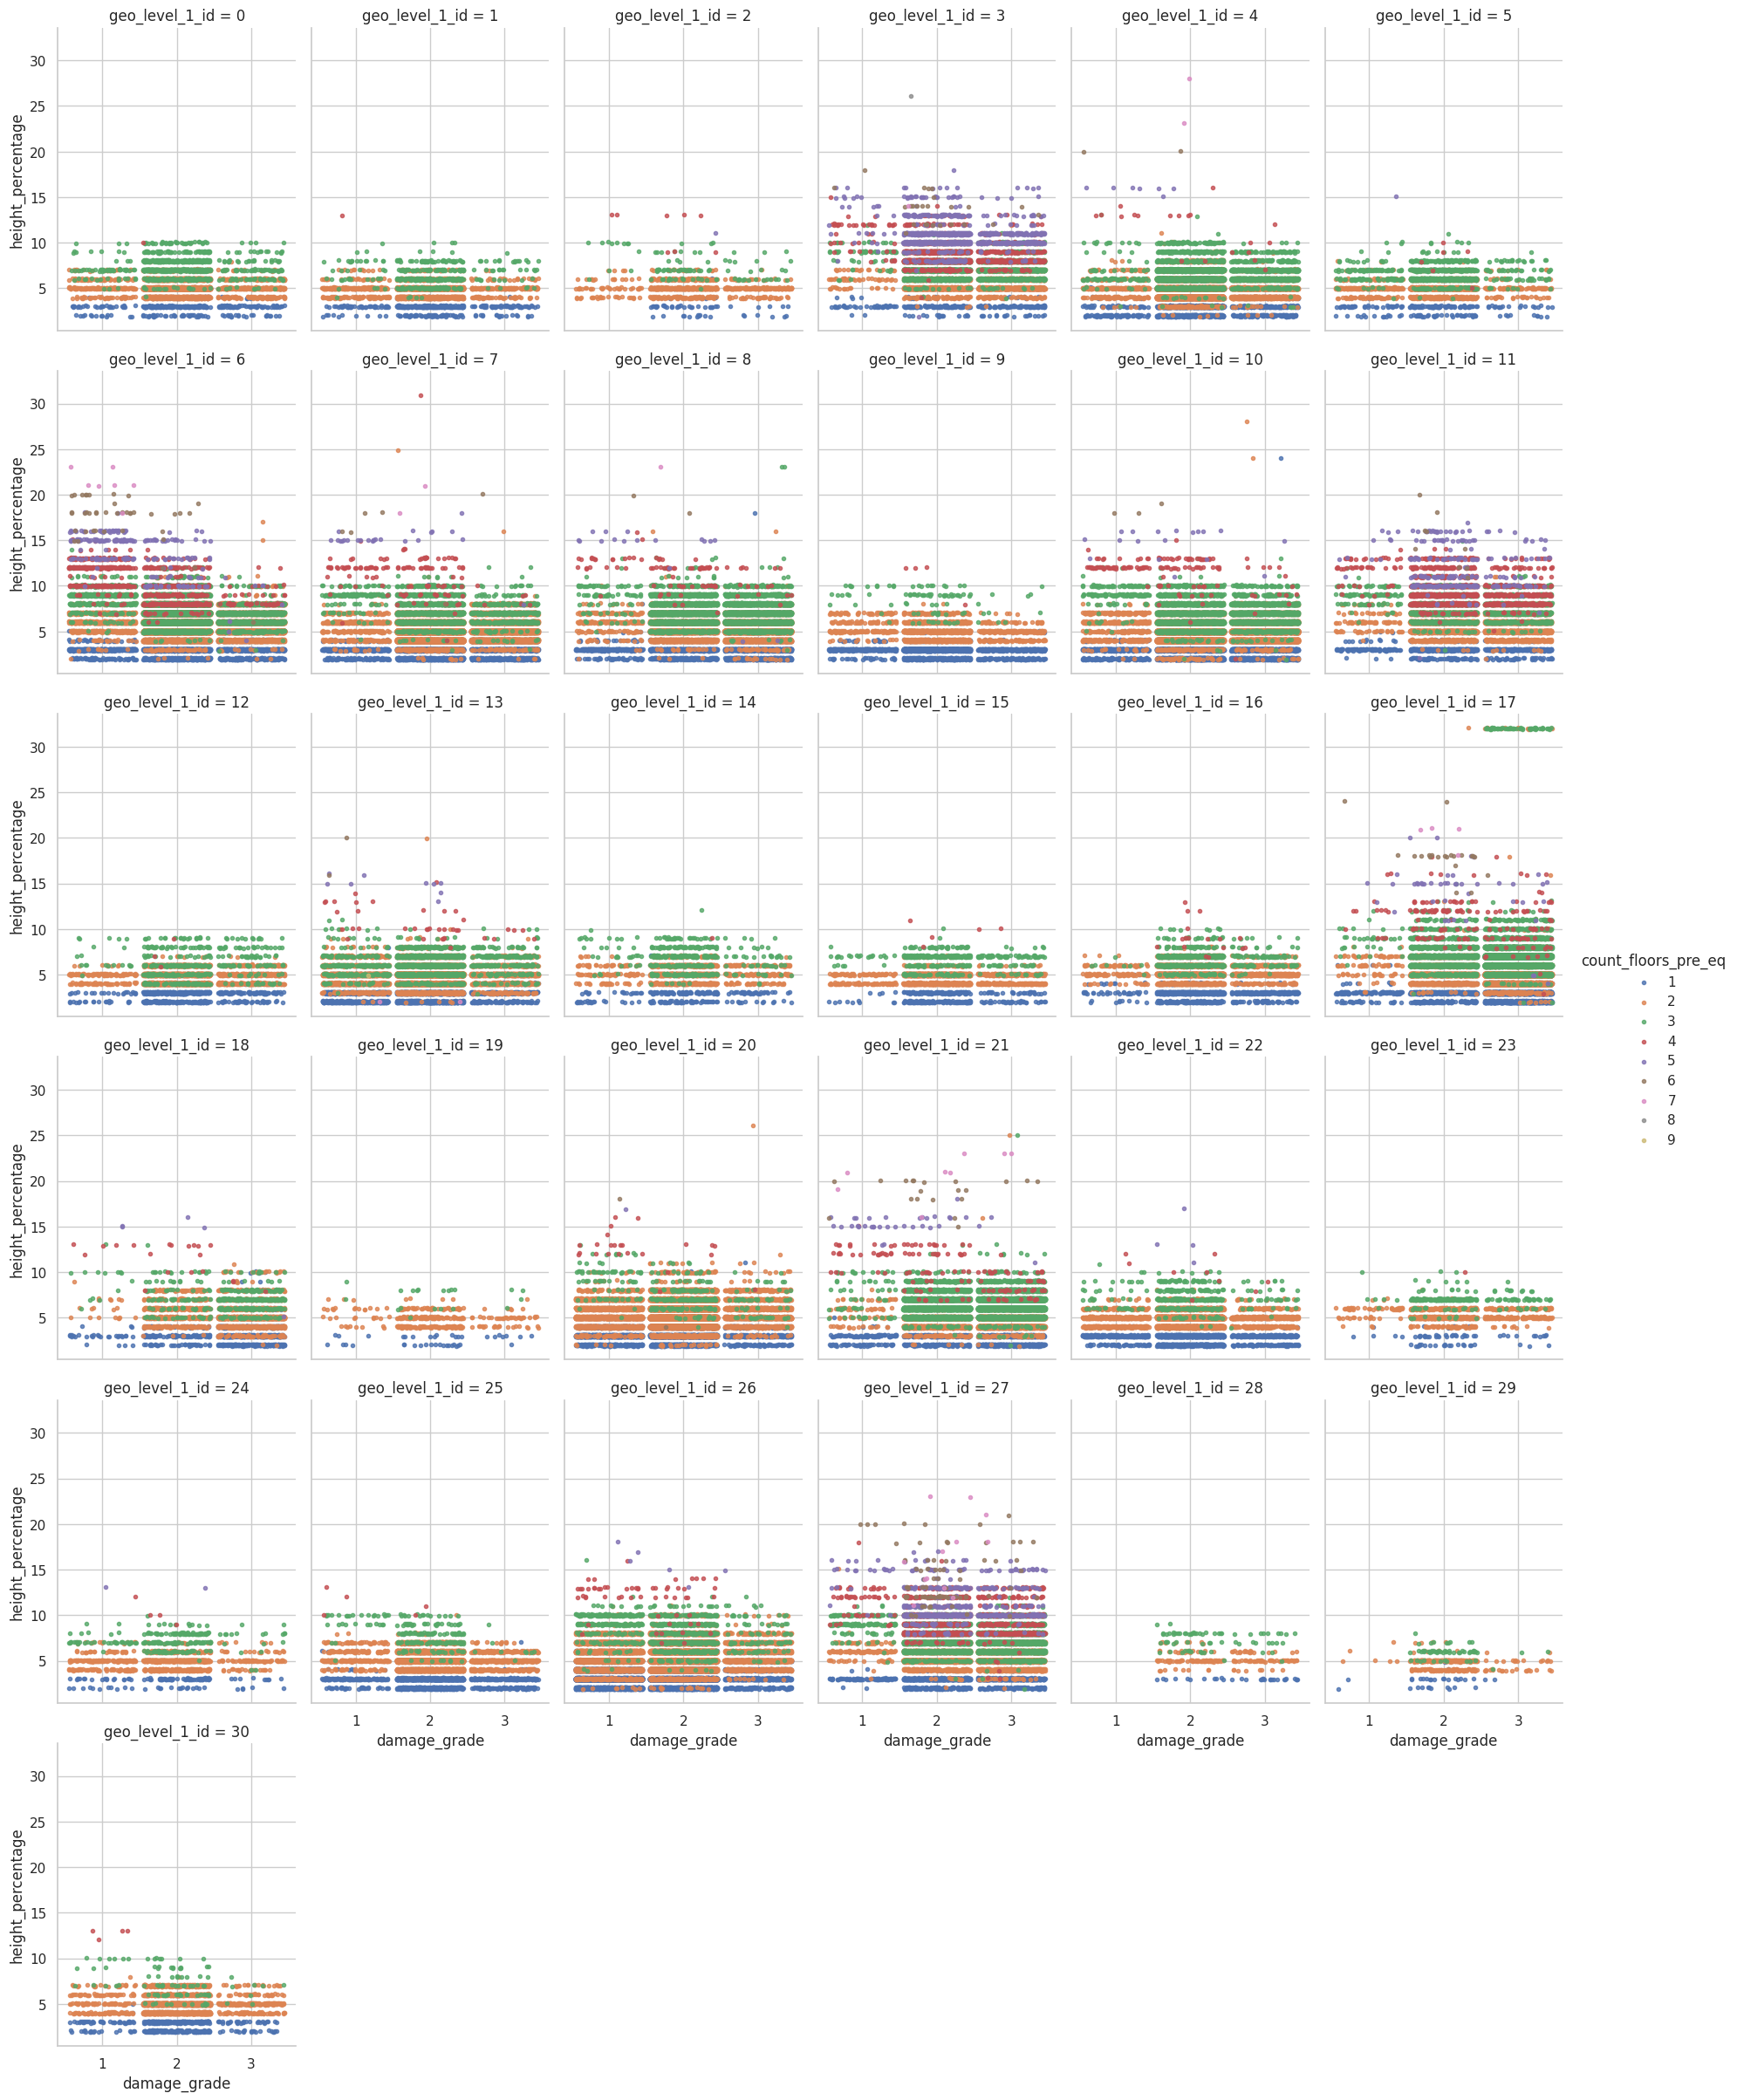

In [445]:
# y para indagar algo raro en la distribucion de alturas por cada cantidad de pisos, lo hacemos por cada geo_level_1_id para ver el comportamiento

sns.lmplot(data=earthquakes, x='damage_grade', y='height_percentage', markers='.'\
           ,y_jitter=0.1,x_jitter=0.45,fit_reg=False,height=4, aspect=0.75\
           ,hue='count_floors_pre_eq',col_wrap=6,col='geo_level_1_id')


In [446]:
# se evaluó el campo geo_level_1_id vs el damage_grade
# con un grafico de barras apiladas de porcentajes (la suma da 100%)
# para esto se realiza un subdataset agrupando por geo_level_1_id y damage_grade
# se pasa cada valor de damage_grade como columnas
# y se agrega una suma total de registros por cada geo_level_1_id

subgeolevel1=earthquakes.groupby(['geo_level_1_id','damage_grade']).size().unstack()
subgeolevel1.columns=subgeolevel1.columns.get_level_values(0)
subgeolevel1.reset_index(inplace=True)
subgeolevel1.drop(columns='geo_level_1_id',inplace=True)
subgeolevel1['total']=subgeolevel1.iloc[:,[0,1,2]].sum(axis=1)
subgeolevel1.columns = ['damage_grade_1', 'damage_grade_2', 'damage_grade_3', 'total']

subgeolevel1

damage_grade_1  ...                total
0                337.00  ...             4,011.00
1                411.00  ...             2,701.00
2                 85.00  ...               931.00
3                245.00  ...             7,540.00
4                521.00  ...            14,568.00
5                446.00  ...             2,690.00
6              2,108.00  ...            24,381.00
7              1,033.00  ...            18,994.00
8                654.00  ...            19,080.00
9                561.00  ...             3,958.00
10             1,211.00  ...            22,079.00
11               386.00  ...             8,220.00
12               199.00  ...             3,194.00
13             1,966.00  ...             9,608.00
14               191.00  ...             1,714.00
15               163.00  ...             2,320.00
16               200.00  ...             4,332.00
17               285.00  ...            21,813.00
18                72.00  ...             3,189.00
19                43.00  ...               372.00
20             3,311.00  ...            17,216.00
21               322.00  ...            14,889.00
22               811.00  ...             6,252.00
23                72.00  ...             1,121.00
24               270.00  ...             1,310.00
25               468.00  ...             5,624.00
26             8,028.00  ...            22,615.00
27               465.00  ...            12,532.00
28                  nan  ...               265.00
29                 8.00  ...               396.00
30               252.00  ...             2,686.00

[31 rows x 4 columns]

Text(0, 0.5, 'damage_grade percentage')

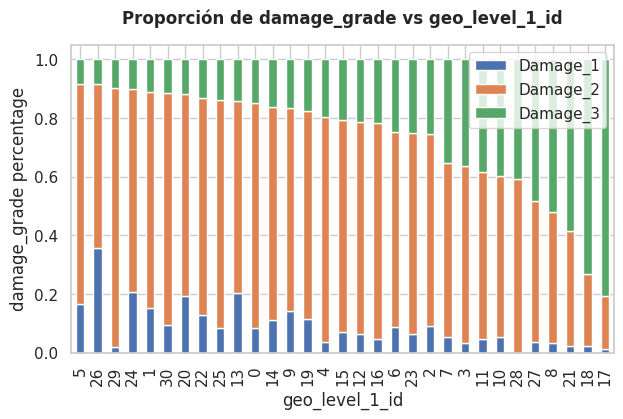

In [447]:
# luego se incorporan campos para porcentajes por cada damage_grade
# y algunos para ordenamiento de las barras en el gráfico y se plotea

subgeolevel1=subgeolevel1.assign(Damage_1 = lambda x: x['damage_grade_1']/x.total)
subgeolevel1=subgeolevel1.assign(Damage_2 = lambda x: x['damage_grade_2']/x.total)
subgeolevel1=subgeolevel1.assign(Damage_3 = lambda x: x['damage_grade_3']/x.total)
subgeolevel1=subgeolevel1.assign(Damage_1y3 = lambda x: x.Damage_1+x.Damage_3)
subgeolevel1.fillna(0,inplace=True)
subgeolevel1.sort_values(by=['Damage_3','Damage_1y3','Damage_2'],inplace=True)
plt.rcParams['figure.figsize'] = (7, 4)
subgeolevel1.iloc[:,[4,5,6]].plot(kind='bar',stacked=True)

plt.title("Proporción de damage_grade vs geo_level_1_id", pad=15, fontweight='bold')
plt.xlabel("geo_level_1_id")
plt.ylabel("damage_grade percentage")

In [448]:
# dada la relacion vista entre la cantidad de pisos y el porcentaje de altura,
# se determina utilizar la altura para un ratio con el area
# el mismo se genera como un nuevo campo en earthquakes2

earthquakes2['ratio_edificio']=earthquakes2['height_percentage']/earthquakes2['area_percentage']

Text(0.5, 1.0, 'damage_grade vs age')

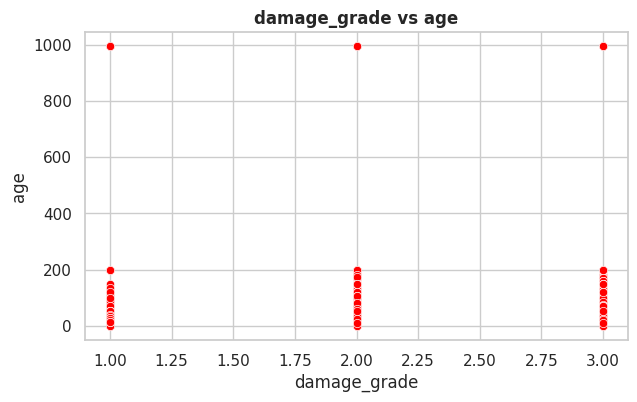

In [449]:
# analizamos la relación entre damage_grade vs age a través de un scatter plot 

sc = sns.scatterplot(data=earthquakes, x='damage_grade', y='age', color='red')
plt.title("damage_grade vs age", fontsize=12, fontweight='bold')


Text(0.5, 1.0, 'damage_grade vs age')

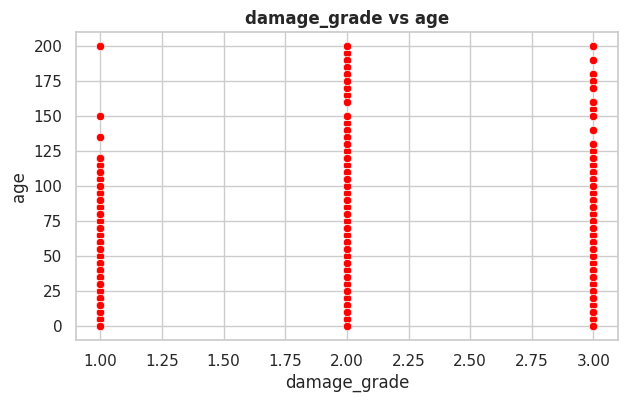

In [450]:
# a partir del gráfico anterior, podríamos considerar que age = 995 es un outlier, así que podríamos eliminar del dataset las rows que correspondan a esa antiguedad. 
earthquakes_less_900 = earthquakes.loc[lambda earthquakes : earthquakes['age'] < 900]

sns.scatterplot(data=earthquakes_less_900, x='damage_grade', y='age', color='red')
plt.title("damage_grade vs age", fontsize=12, fontweight='bold')

Text(0.5, 1.05, 'Distribución de antiguedad de las edificaciones menores a 900 años vs cantidad')

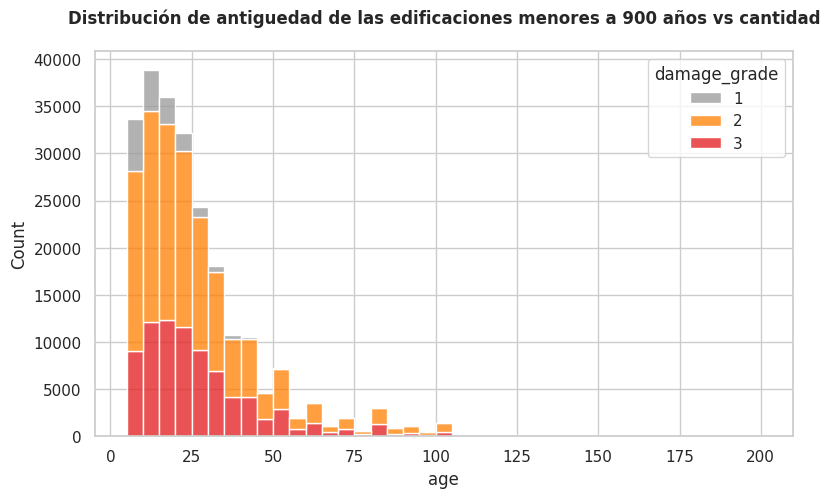

In [451]:
# generamos histogramas de distribucion de datos de antiguedad
# con un doble filtro de antiguedad en el segundo plot

filtro_age_min=earthquakes2['age']>0
earthquakes3=earthquakes2[filtro_age_min]
filtro_age_max=earthquakes3['age']<=900
plt.rcParams['figure.figsize'] = (9, 5)
hp = sns.histplot(earthquakes3[filtro_age_max], x="age",stat='count'\
             ,binwidth=5,hue='damage_grade',multiple="stack",palette='Set1_r')

hp.set_title("Distribución de antiguedad de las edificaciones menores a 900 años vs cantidad", fontsize=12, fontweight='bold', y=1.05)

Text(0.5, 1.05, 'Detalle de la distribución de antiguedad de las edificaciones entre 50 y 900 años vs cantidad en relación al damage_grade')

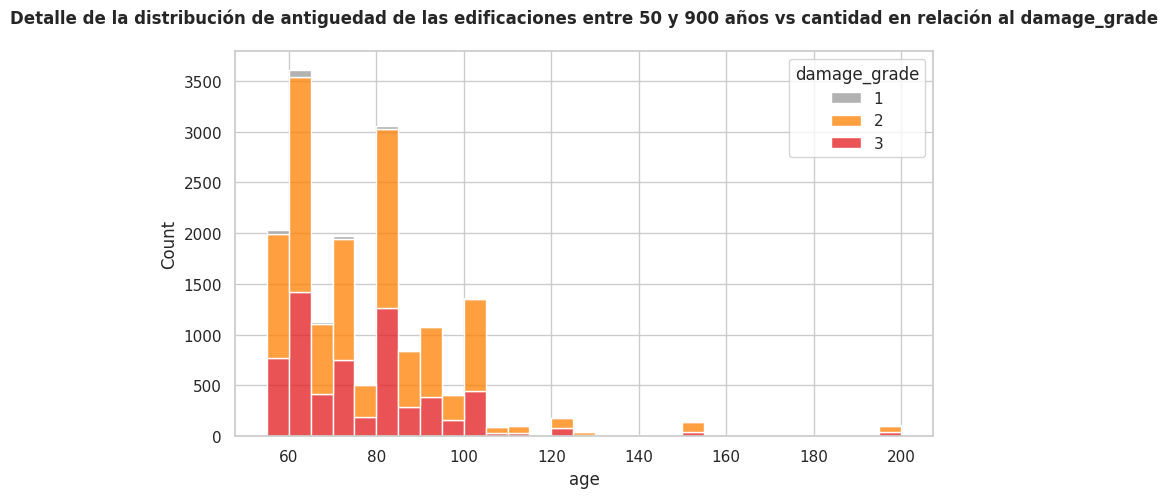

In [452]:
filtro_age_min=earthquakes2['age']>50
earthquakes3=earthquakes2[filtro_age_min]
filtro_age_max=earthquakes3['age']<=900
plt.rcParams['figure.figsize'] = (9, 5)
hp = sns.histplot(earthquakes3[filtro_age_max], x="age",stat='count'\
             ,binwidth=5,hue='damage_grade',multiple="stack",palette='Set1_r')

hp.set_title("Detalle de la distribución de antiguedad de las edificaciones entre 50 y 900 años vs cantidad en relación al damage_grade", fontsize=12, fontweight='bold', y=1.05)

In [453]:
#generamos dos filtros para quitar las antiguedades mayores a 900 años y los ratios mayores a 8

antiguedad900=earthquakes2['age']<=900
ratiosmenor8=earthquakes2['ratio_edificio']<=8

In [454]:
#aplicamos ambos filtros a earthquakes2

earthquakes2=earthquakes2[antiguedad900]
earthquakes2=earthquakes2[ratiosmenor8]
earthquakes2.describe()

geo_level_1_id  ...       ratio_edificio
count           259,134.00  ...           259,134.00
mean                 13.89  ...                 0.81
std                   8.03  ...                 0.44
min                   0.00  ...                 0.03
25%                   7.00  ...                 0.53
50%                  12.00  ...                 0.71
75%                  21.00  ...                 1.00
max                  30.00  ...                 8.00

[8 rows x 8 columns]

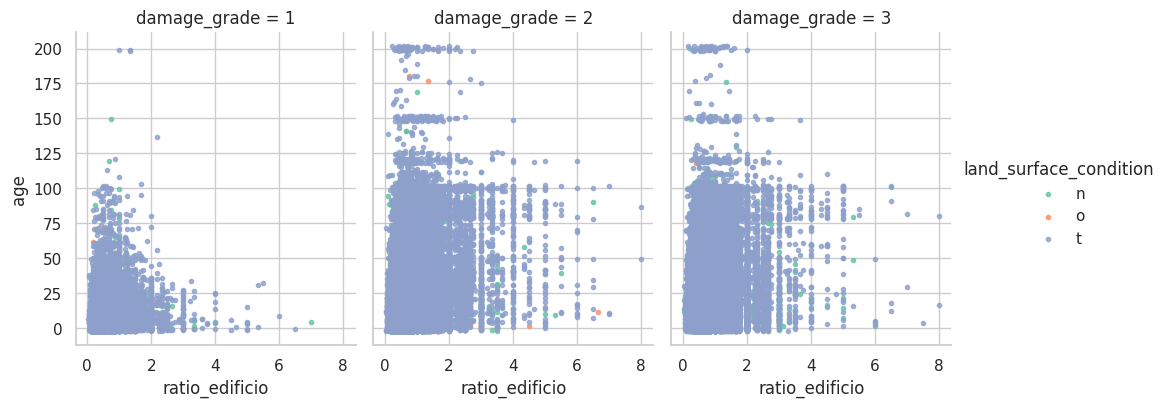

In [455]:
# generamos un pack de scatter (uno por cada damage) de Ratio vs Age,
# donde los colores representan la variable categorica elegida (ej: ground_floor_type)

sns.lmplot(data=earthquakes2, y='age', x='ratio_edificio',fit_reg=False\
           , col='damage_grade', col_wrap=3,hue='land_surface_condition'\
           , legend=True,size=4,markers='.',palette='Set2',aspect=.8,y_jitter=2)
#plt.legend(loc='upper',title='ground_floor_type')

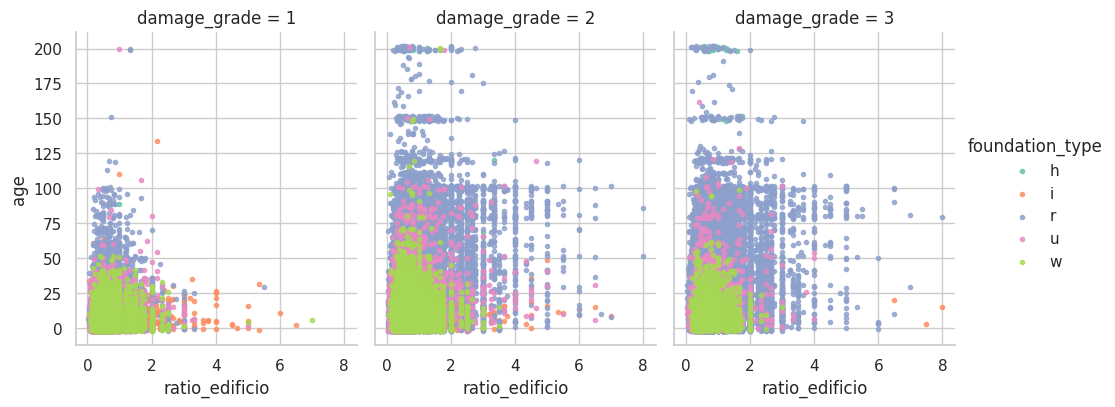

In [456]:
#generamos un pack de scatter (uno por cada damage) de Ratio vs Age,
# donde los colores representan la variable categorica elegida (ej: ground_floor_type)

sns.lmplot(data=earthquakes2, y='age', x='ratio_edificio',fit_reg=False\
           , col='damage_grade', col_wrap=3,hue='foundation_type'\
           , legend=True,size=4,markers='.',palette='Set2',aspect=.8,y_jitter=2)
#plt.legend(loc='upper',title='ground_floor_type')

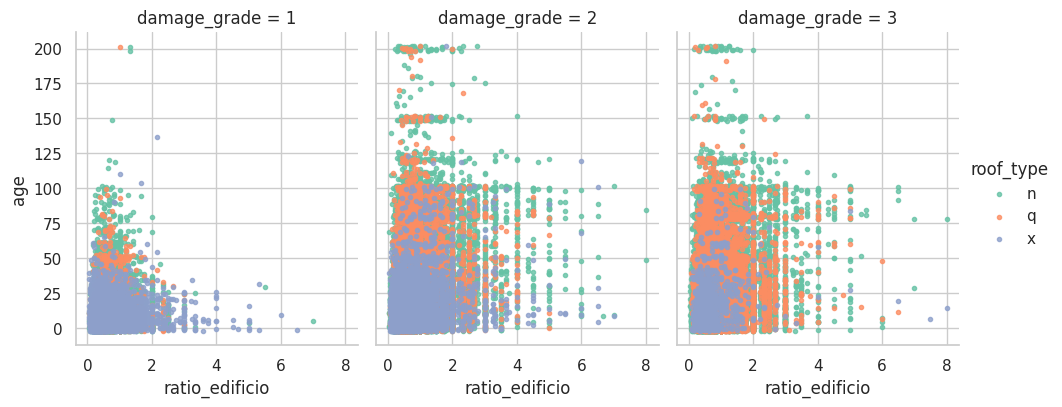

In [457]:
#generamos un pack de scatter (uno por cada damage) de Ratio vs Age,
# donde los colores representan la variable categorica elegida (ej: ground_floor_type)

sns.lmplot(data=earthquakes2, y='age', x='ratio_edificio',fit_reg=False\
           , col='damage_grade', col_wrap=3,hue='roof_type'\
           , legend=True,size=4,markers='.',palette='Set2',aspect=.8,y_jitter=2)
#plt.legend(loc='upper',title='ground_floor_type')

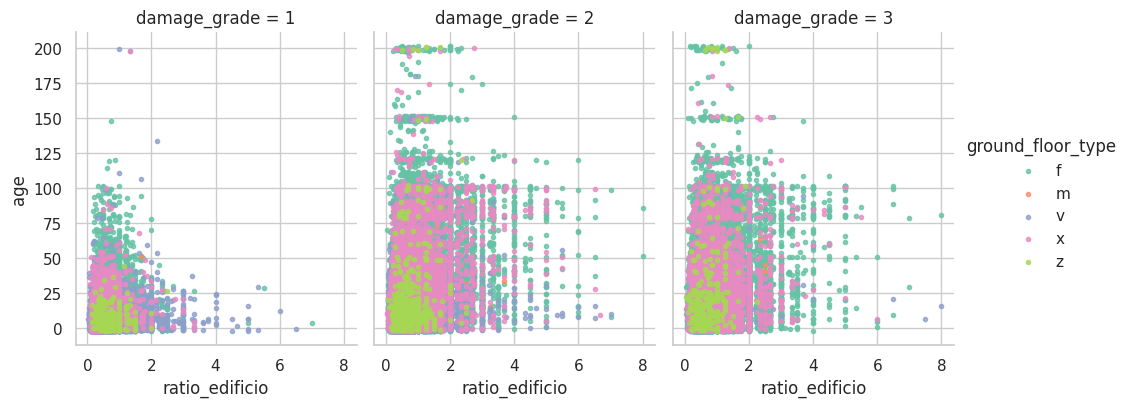

In [458]:
#generamos un pack de scatter (uno por cada damage) de Ratio vs Age,
# donde los colores representan la variable categorica elegida (ej: ground_floor_type)

sns.lmplot(data=earthquakes2, y='age', x='ratio_edificio',fit_reg=False\
           , col='damage_grade', col_wrap=3,hue='ground_floor_type'\
           , legend=True,size=4,markers='.',palette='Set2',aspect=.8,y_jitter=2)
#plt.legend(loc='upper',title='ground_floor_type')

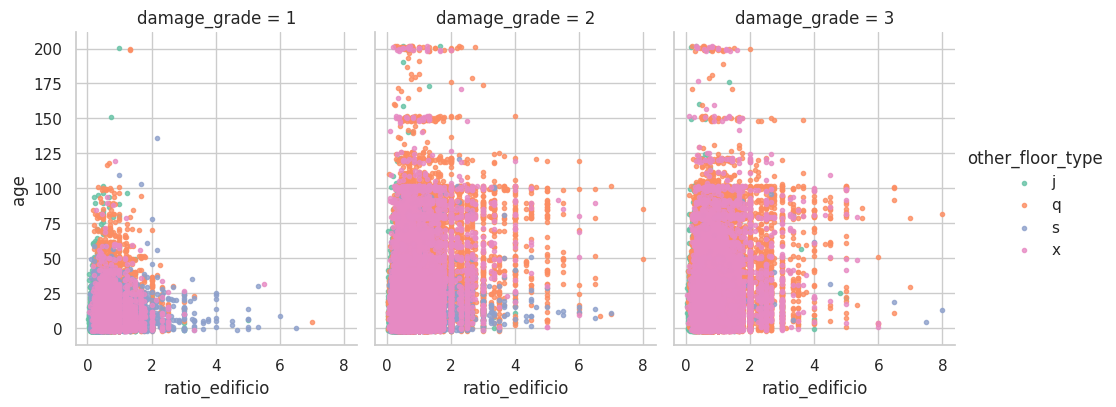

In [459]:
#generamos un pack de scatter (uno por cada damage) de Ratio vs Age,
# donde los colores representan la variable categorica elegida (ej: ground_floor_type)

sns.lmplot(data=earthquakes2, y='age', x='ratio_edificio',fit_reg=False\
           , col='damage_grade', col_wrap=3,hue='other_floor_type'\
           , legend=True,size=4,markers='.',palette='Set2',aspect=.8,y_jitter=2)
#plt.legend(loc='upper',title='ground_floor_type')

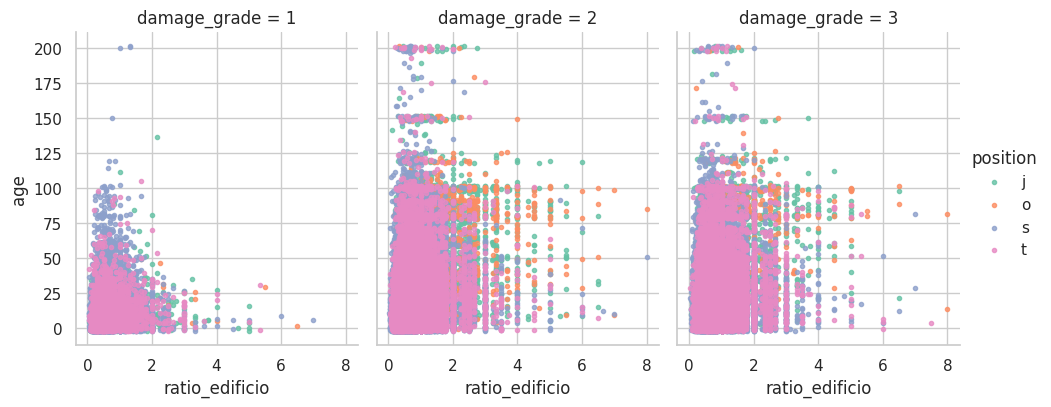

In [460]:
#generamos un pack de scatter (uno por cada damage) de Ratio vs Age,
# donde los colores representan la variable categorica elegida (ej: ground_floor_type)

sns.lmplot(data=earthquakes2, y='age', x='ratio_edificio',fit_reg=False\
           , col='damage_grade', col_wrap=3,hue='position'\
           , legend=True,size=4,markers='.',palette='Set2',aspect=.8,y_jitter=2)
#plt.legend(loc='upper',title='ground_floor_type')

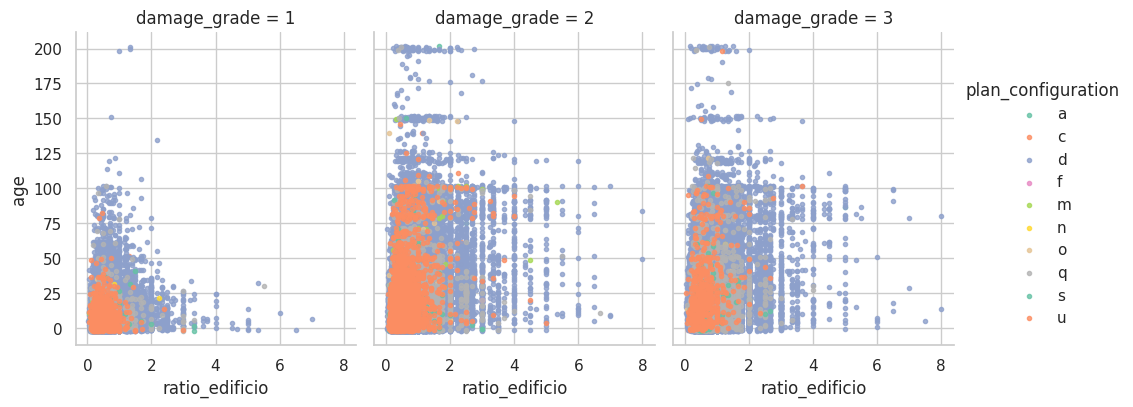

In [461]:
#generamos un pack de scatter (uno por cada damage) de Ratio vs Age,
# donde los colores representan la variable categorica elegida (ej: ground_floor_type)

sns.lmplot(data=earthquakes2, y='age', x='ratio_edificio',fit_reg=False\
           , col='damage_grade', col_wrap=3,hue='plan_configuration'\
           , legend=True,size=4,markers='.',palette='Set2',aspect=.8,y_jitter=2)
#plt.legend(loc='upper',title='ground_floor_type')

In [462]:
earthquakes_by_floor_dg1 = earthquakes.loc[earthquakes['damage_grade'] == 1,['count_floors_pre_eq','damage_grade']].groupby(by=['count_floors_pre_eq']).count()
earthquakes_by_floor_dg2 = earthquakes.loc[earthquakes['damage_grade'] == 2,['count_floors_pre_eq','damage_grade']].groupby(by=['count_floors_pre_eq']).count()
earthquakes_by_floor_dg3 = earthquakes.loc[earthquakes['damage_grade'] == 3,['count_floors_pre_eq','damage_grade']].groupby(by=['count_floors_pre_eq']).count()

level0 = earthquakes_by_floor_dg1.columns.get_level_values(0)
earthquakes_by_floor_dg1.columns = level0
earthquakes_by_floor_dg1.reset_index(inplace=True)

level0 = earthquakes_by_floor_dg2.columns.get_level_values(0)
earthquakes_by_floor_dg2.columns = level0
earthquakes_by_floor_dg2.reset_index(inplace=True)

level0 = earthquakes_by_floor_dg3.columns.get_level_values(0)
earthquakes_by_floor_dg3.columns = level0
earthquakes_by_floor_dg3.reset_index(inplace=True)

earthquakes_by_floor = pd.merge(earthquakes_by_floor_dg1, earthquakes_by_floor_dg2, how="inner", on="count_floors_pre_eq")
earthquakes_by_floor = pd.merge(earthquakes_by_floor, earthquakes_by_floor_dg3, how="inner", on="count_floors_pre_eq")
earthquakes_by_floor = earthquakes_by_floor.rename(columns = {"damage_grade_x": "damage_grade_1", "damage_grade_y": "damage_grade_2", "damage_grade": "damage_grade_3"})
earthquakes_by_floor = earthquakes_by_floor.set_index('count_floors_pre_eq')
earthquakes_by_floor

damage_grade_1  damage_grade_2  damage_grade_3
count_floors_pre_eq                                                
1                              8969           20798           10674
2                             12593           93968           50062
3                              2537           28479           24601
4                               707            3374            1343
5                               254            1481             511
6                                53             133              23
7                                10              25               4

Text(0, 0.5, 'damage_grade')

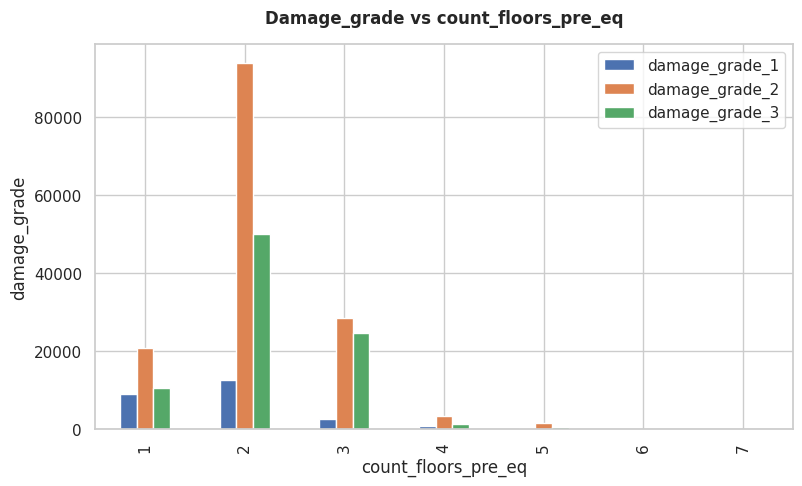

In [463]:
earthquakes_by_floor.plot(kind="bar")
plt.title("Damage_grade vs count_floors_pre_eq", pad=15, fontweight='bold')
plt.xlabel("count_floors_pre_eq")
plt.ylabel("damage_grade")


In [464]:
# para ver si hay alguna tendencia entre las variables geo_level_1_id y count_floors_pre_eq, por ejemplo, si hay mayor cantidad de edificaciones con más pisos en alguna zona. 

def q25(x):
    return x.quantile(0.5)

def q75(x):
    return x.quantile(0.75)

earthquakes2.loc[:,['count_floors_pre_eq', 'damage_grade']].groupby(by=['count_floors_pre_eq']).agg({'damage_grade':[np.median, np.min, np.max, q25,q75]})

damage_grade                  
                          median amin amax q25 q75
count_floors_pre_eq                               
1                              2    1    3   2   3
2                              2    1    3   2   3
3                              2    1    3   2   3
4                              2    1    3   2   2
5                              2    1    3   2   2
6                              2    1    3   2   2
7                              2    1    3   2   2
8                              2    2    2   2   2
9                              1    1    1   1   1

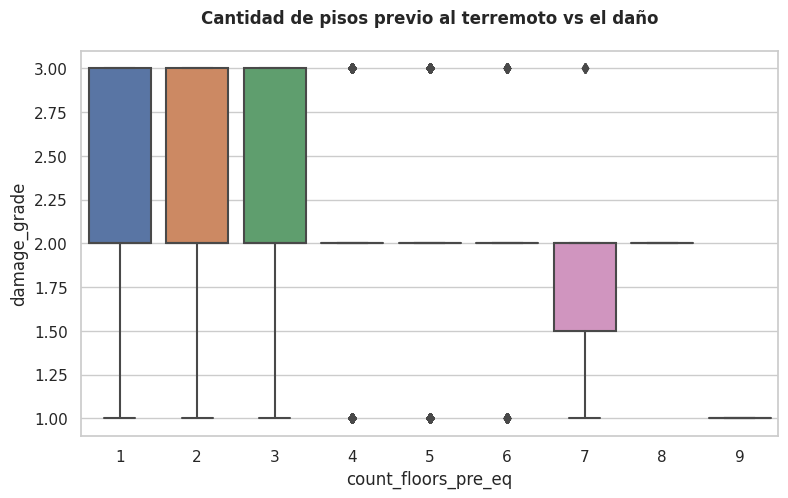

In [465]:
ax = sns.boxplot(x="count_floors_pre_eq", y="damage_grade", data=earthquakes2).set_title("Cantidad de pisos previo al terremoto vs el daño", fontsize=12, fontweight='bold', y=1.05)

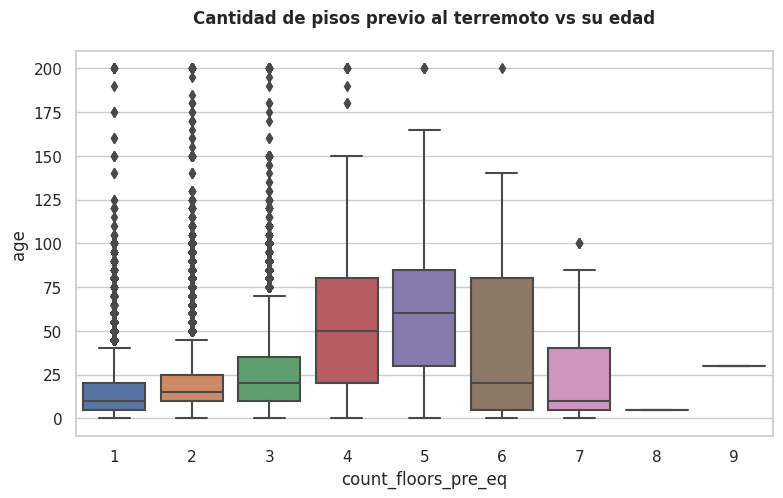

In [466]:
# para analizar la relación entre la edad de la edificación y los pisos
ax = sns.boxplot(x="count_floors_pre_eq", y="age", data=earthquakes2).set_title("Cantidad de pisos previo al terremoto vs su edad", fontsize=12, fontweight='bold', y=1.05)

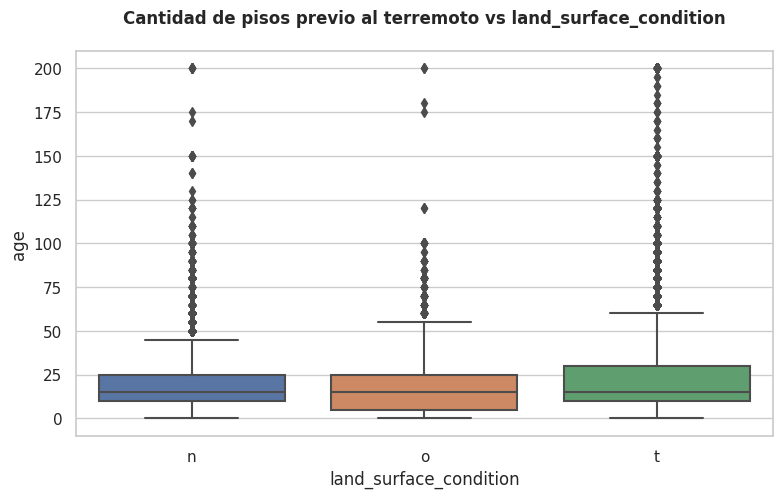

In [467]:
# analizamos la relación entre land_surface_condition con respecto a la antiguedad
ax = sns.boxplot(x="land_surface_condition", y="age", data=earthquakes2).set_title("Cantidad de pisos previo al terremoto vs land_surface_condition", fontsize=12, fontweight='bold', y=1.05)

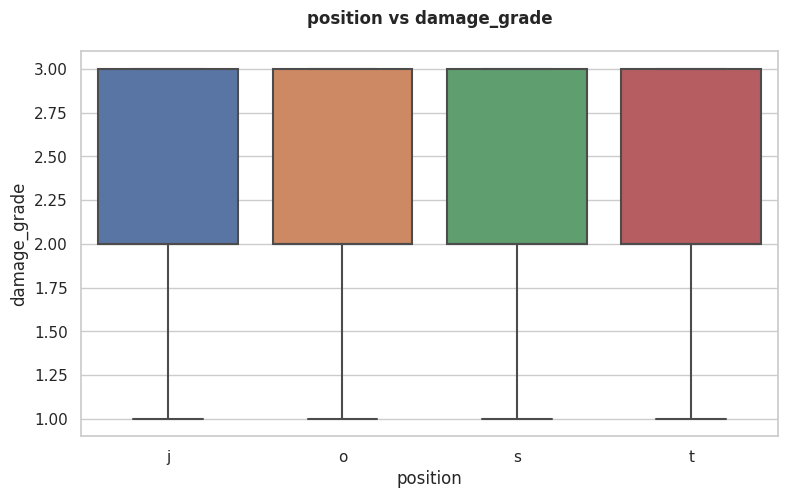

In [468]:
ax = sns.boxplot(x="position", y="damage_grade", data=earthquakes2).set_title("position vs damage_grade", fontsize=12, fontweight='bold', y=1.05)

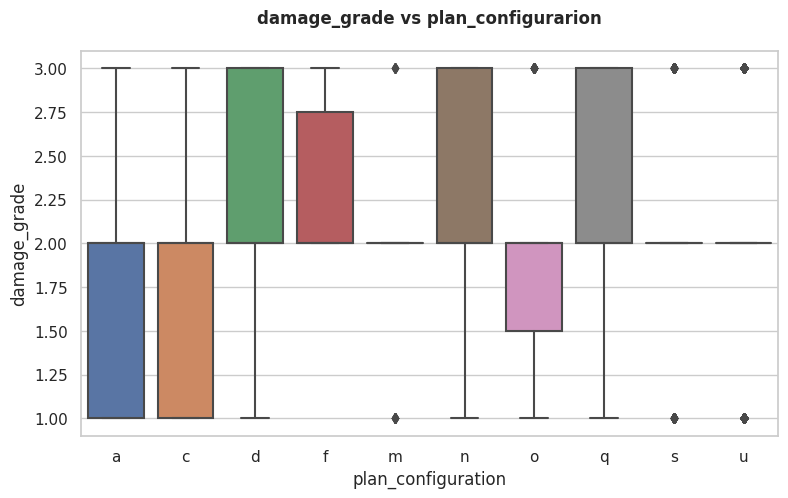

In [469]:
ax = sns.boxplot(x="plan_configuration", y="damage_grade", data=earthquakes2).set_title("damage_grade vs plan_configurarion", fontsize=12, fontweight='bold', y=1.05)

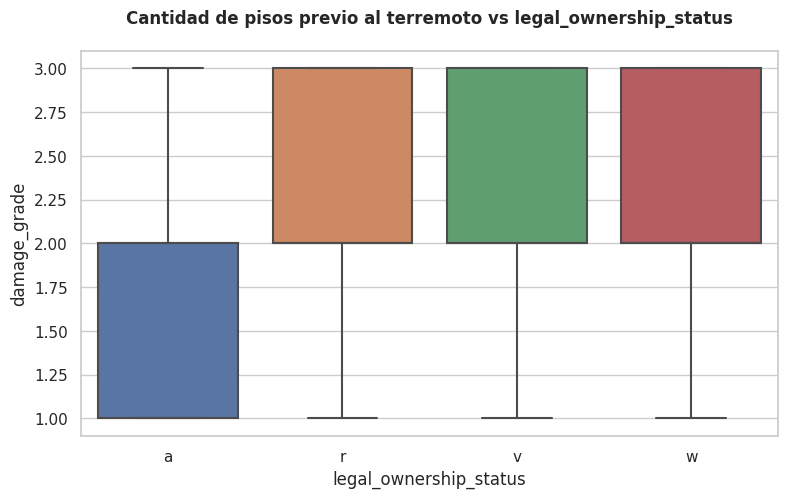

In [470]:
# analizamos legal_ownership_status vs damage_grade para ver si tienen alguna relación
ax = sns.boxplot(x="legal_ownership_status", y="damage_grade", data=earthquakes2).set_title("Cantidad de pisos previo al terremoto vs legal_ownership_status", fontsize=12, fontweight='bold', y=1.05)

Text(0.5, 1.0, 'count_floors_pre_eq vs count_families')

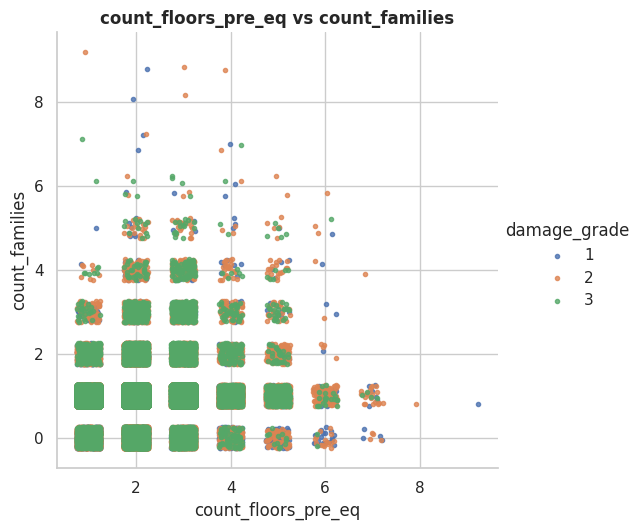

In [471]:
#

sns.lmplot(data=earthquakes2, x='count_floors_pre_eq', y='count_families', x_jitter=0.25, y_jitter=0.25, hue='damage_grade', fit_reg=False, markers='.')
plt.title("count_floors_pre_eq vs count_families", fontsize=12, fontweight='bold')

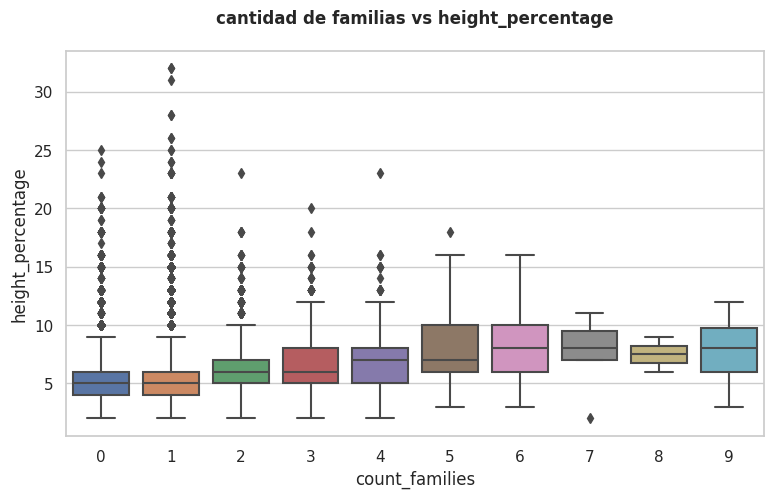

In [472]:
# analizamos legal_ownership_status vs damage_grade para ver la distribución de los datos
ax = sns.boxplot(x="count_families", y="height_percentage", data=earthquakes2).set_title("cantidad de familias vs height_percentage", fontsize=12, fontweight='bold', y=1.05)

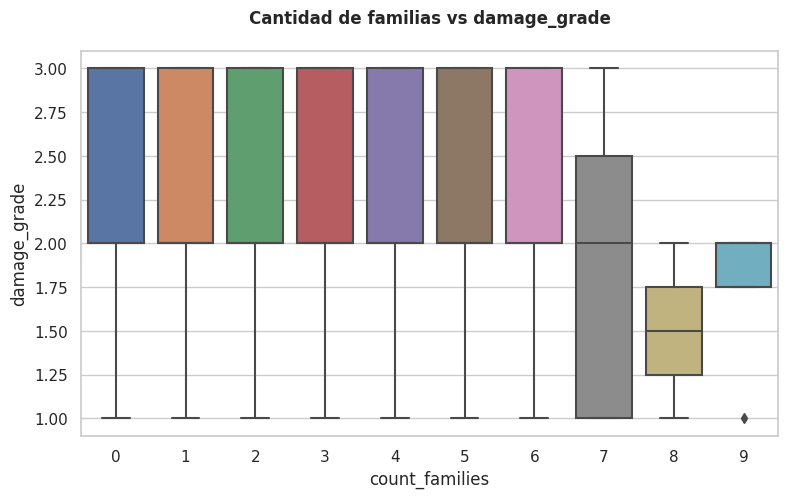

In [473]:
# analizamos legal_ownership_status vs damage_grade para ver si tienen alguna relación
ax = sns.boxplot(x="count_families", y="damage_grade", data=earthquakes2).set_title("Cantidad de familias vs damage_grade", fontsize=12, fontweight='bold', y=1.05)

In [474]:
# analizamos la relación entre la antiguedad y el material de construcción

earthquakes_by_construction_material = earthquakes2.loc[:,['age','has_superstructure_adobe_mud', \
                                                          'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', \
                                                          'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', \
                                                          'has_superstructure_timber', 'has_superstructure_bamboo', \
                                                          'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', \
                                                          'has_superstructure_other', 'has_superstructure_cement_mortar_brick', 'damage_grade']]


earthquakes_by_construction_material

age  ...  damage_grade
0        30  ...             3
1        10  ...             2
2        10  ...             3
3        10  ...             2
4        30  ...             3
...     ...  ...           ...
260596   55  ...             2
260597    0  ...             3
260598   55  ...             3
260599   10  ...             2
260600   10  ...             3

[259134 rows x 13 columns]

In [475]:
def asignarCodigo(df):
  newColumn = []
  for index,row in df.iterrows():
    newValue = ''
    if (row['has_superstructure_adobe_mud'] == 1):
      newValue += 'A'
    if (row['has_superstructure_mud_mortar_stone'] == 1):
      newValue += 'B'
    if (row['has_superstructure_stone_flag'] == 1):
      newValue += 'C'
    if (row['has_superstructure_cement_mortar_stone'] == 1):
      newValue += 'D'
    if (row['has_superstructure_mud_mortar_brick'] == 1):
      newValue += 'E'
    if (row['has_superstructure_cement_mortar_brick'] == 1):
      newValue += 'F'
    if (row['has_superstructure_timber'] == 1):
      newValue += 'G'
    if (row['has_superstructure_bamboo'] == 1):
      newValue += 'H'
    if (row['has_superstructure_rc_non_engineered'] == 1):
      newValue += 'I'
    if (row['has_superstructure_rc_engineered'] == 1):
      newValue += 'J'
    if (row['has_superstructure_other'] == 1):
      newValue += 'K'
    newColumn.append(newValue)
  return newColumn
       

materials = asignarCodigo(earthquakes_by_construction_material)


In [476]:
material_det = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone','has_superstructure_stone_flag','has_superstructure_cement_mortar_stone',
                'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick','has_superstructure_timber','has_superstructure_bamboo',
                'has_superstructure_rc_non_engineered','has_superstructure_rc_engineered','has_superstructure_other'] 
letras = ['A','B','C','D','E','F','G','H','I','J','K']

detalle = {'material': material_det, 'letra': letras}
detalle = pd.DataFrame(data=detalle)
detalle

material letra
0             has_superstructure_adobe_mud     A
1      has_superstructure_mud_mortar_stone     B
2            has_superstructure_stone_flag     C
3   has_superstructure_cement_mortar_stone     D
4      has_superstructure_mud_mortar_brick     E
5   has_superstructure_cement_mortar_brick     F
6                has_superstructure_timber     G
7                has_superstructure_bamboo     H
8     has_superstructure_rc_non_engineered     I
9         has_superstructure_rc_engineered     J
10                has_superstructure_other     K

In [477]:
earthquakes_by_construction_material = earthquakes_by_construction_material.loc[:,['age', 'damage_grade']]
earthquakes_by_construction_material['materials'] = materials
earthquakes_by_construction_material

age  damage_grade materials
0        30             3        AB
1        10             2         B
2        10             3         B
3        10             2       BGH
4        30             3         A
...     ...           ...       ...
260596   55             2         B
260597    0             3         B
260598   55             3         B
260599   10             2         F
260600   10             3         B

[259134 rows x 3 columns]

In [478]:
earthquakes_by_construction_material = earthquakes_by_construction_material.groupby(by=['materials']).agg({'age':np.mean, 'damage_grade':np.mean}).reset_index(inplace=False)
earthquakes_by_construction_material

materials                  age         damage_grade
0           A                30.66                 2.37
1          AB                26.23                 2.31
2         ABC                23.13                 2.59
3        ABCD                18.89                 2.11
4       ABCDE                25.00                 3.00
..        ...                  ...                  ...
498       IJK                 5.00                 2.00
499        IK                12.50                 2.00
500         J                 6.87                 1.33
501        JK                13.75                 2.25
502         K                 8.11                 1.62

[503 rows x 3 columns]

In [479]:
earthquakes_by_construction_material_moreThan50 = earthquakes_by_construction_material[earthquakes_by_construction_material['age']>50]
earthquakes_by_construction_material_moreThan50

materials                  age         damage_grade
7    ABCDEFGI                70.00                 2.00
8     ABCDEFI                73.00                 2.00
11    ABCDEGI                75.00                 2.00
12     ABCDFI                65.00                 2.00
16     ABCDGI                65.00                 2.33
17      ABCDI                71.00                 2.40
22    ABCEFGI                55.00                 3.00
23     ABCEFI                65.00                 3.00
33     ABCFGI                65.00                 3.00
34     ABCFHK                95.00                 2.00
35      ABCFI                65.00                 3.00
50     ABDEFI                65.00                 2.00
62     ABDGHK                60.00                 2.00
72      ABEFK                90.00                 2.50
110     ACDFI                65.00                 2.00
132     ADEFG                55.00                 2.00
140    ADEGHK                60.00                 2.50
159      AEFG                69.17                 2.19
162     AEFGI                62.50                 2.50
164     AEFGK                80.00                 2.00
168      AEFK                53.33                 2.33
169       AEG                55.06                 2.39
176       AEH                54.51                 2.49
177      AEHI                80.00                 3.00
179       AEI                60.00                 2.50
183       AFG                68.37                 2.21
187       AFH                70.00                 2.00
216   BCDEGHK                55.00                 2.00
241    BCFGHK                60.00                 2.50
242      BCFH                55.00                 3.00
315     BFGHK               100.00                 3.00
366       CEI                60.00                 3.00
400       DEK                70.00                 2.00

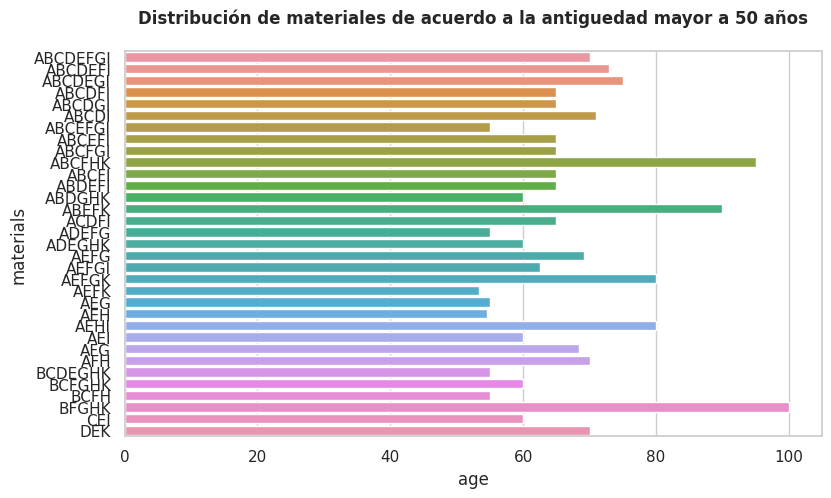

In [480]:
ax = sns.barplot(x='age', y='materials', data=earthquakes_by_construction_material_moreThan50).set_title("Distribución de materiales de acuerdo a la antiguedad mayor a 50 años", fontsize=12, fontweight='bold', y=1.05)

In [481]:
#con el objetivo de generar un HEATMAP 
#generamos un subdataframe solo con los campos boolean de MATERIALES CONSTRUCTIVOS
#renombramos las columnas con un prefijo para que no lo ordene alfabeticamente

boolmaterials=earthquakes.iloc[:,[12,13,14,15,16,17,18,19,20,21,22]]
boolmaterials.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                       '03_cement_mortar_stone','04_mud_mortar_brick',\
                       '05_cement_mortar_brick','06_timber','07_bamboo',\
                       '08_rc_non_engineered','09_rc_engineered','10_other']

# antes de agregarle un campo, generamos una serie con la cantidad de True por cada row
# y filtrando los registros con un solo True, los contamos por cada campo
# esto será usado para completar la diagonal del heatmap

seriediagonal=boolmaterials[boolmaterials[boolmaterials==True].count(axis=1)==1].sum()

# luego le agregamos un campo "contador" para sumar registros

boolmaterials['contador']=1

In [482]:
#iteramos entre los 11 campos boolean, para generar por cada uno,
# un pivot_table con la suma de cada match entre dicho campo y los otros 10

for i in range(11):
  filtro_p=boolmaterials[boolmaterials.columns.get_level_values(0)[i]]==True
  prueba_bool_concat=boolmaterials[filtro_p].\
                      pivot_table(index=boolmaterials.columns.\
                      get_level_values(0)[i],columns=['contador'],aggfunc=np.sum)
  if i==0:
    matrizfor=prueba_bool_concat
  else:
    matrizfor=pd.concat([matrizfor,prueba_bool_concat])

In [483]:
#limpiamos los indices y columnas

matrizfor.columns=matrizfor.columns.get_level_values(0)
matrizfor.reset_index(inplace=True)
matrizfor.drop(columns='index',inplace=True)

In [484]:
matrizfor

00_adobe_mud  ...             10_other
0                   nan  ...               864.00
1              7,921.00  ...             2,413.00
2                887.00  ...               513.00
3                277.00  ...               124.00
4              7,454.00  ...               476.00
5              1,005.00  ...               244.00
6              6,268.00  ...             2,436.00
7              2,202.00  ...             1,367.00
8                433.00  ...                48.00
9                 26.00  ...                23.00
10               864.00  ...                  nan

[11 rows x 11 columns]

In [485]:
#reemplazamos los valores del indice, por los nombres de cada row, correspondientes a la columna que representan
#agregamos los datos de la seriediagonal en reemplazo de los valores "nan"

matrizfor['nombres']='abc'
for i in range(11):
  matrizfor['nombres'][i]=matrizfor.columns.get_level_values(0)[i]
  matrizfor[matrizfor.columns.get_level_values(0)[i]][i]=\
  seriediagonal[seriediagonal.index==matrizfor.columns.get_level_values(0)[i]]
matrizfor.set_index('nombres',drop=True, inplace=True)

Text(77.54687499999999, 0.5, 'has_superstructure')

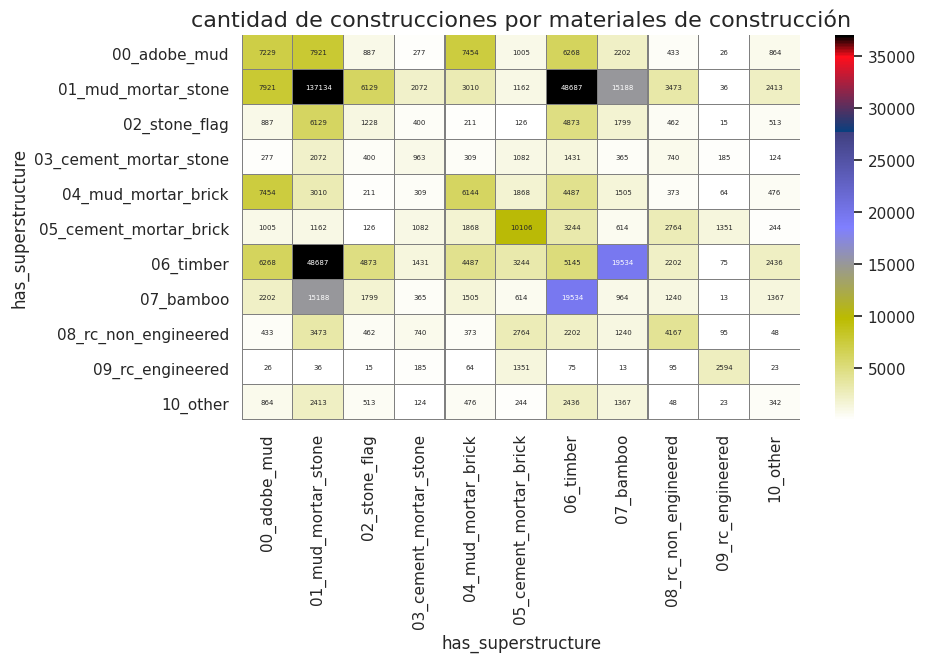

In [486]:
#por último generamos el heatmap

g = sns.heatmap(matrizfor,linewidths=.1,annot=True,annot_kws={"size": 5},\
                cmap="gist_stern_r",fmt='g',robust=True,linecolor='gray')
g.set_title("cantidad de construcciones por materiales de construcción",fontsize=16)
g.set_xlabel("has_superstructure")
g.set_ylabel("has_superstructure")

Text(77.54687499999999, 0.5, 'has_superstructure')

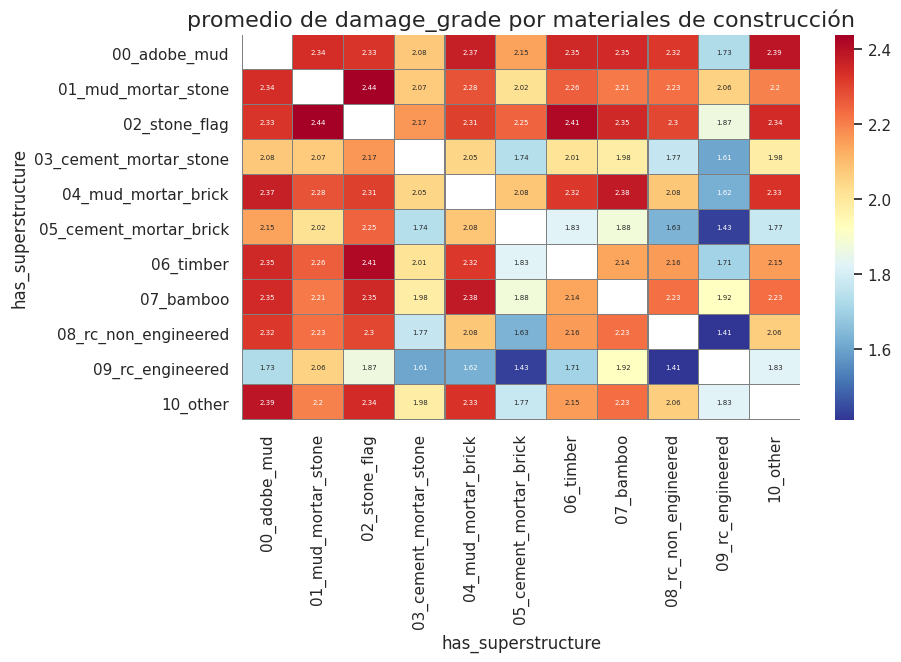

In [487]:
# comenzamos de nuevo para un heatmap de medias de damage

boolmaterials_damage=earthquakes.iloc[:,[12,13,14,15,16,17,18,19,20,21,22,36]]
boolmaterials_damage.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                              '03_cement_mortar_stone','04_mud_mortar_brick',\
                              '05_cement_mortar_brick','06_timber','07_bamboo',\
                              '08_rc_non_engineered','09_rc_engineered','10_other','damage_grade']
for i in range(11):
  boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]=\
  boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]*\
  boolmaterials_damage['damage_grade']
boolmaterials_damage.drop(columns='damage_grade',inplace=True)

for i in range(11):
  filtro_p=boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]>0
  bool_merge=boolmaterials_damage[filtro_p].\
                      pivot_table(index=boolmaterials_damage.columns.\
                      get_level_values(0)[i],aggfunc={np.sum})
  bool_merge.columns=bool_merge.columns.get_level_values(0)
  serie_bool=bool_merge.sum()/matrizfor.loc[:,boolmaterials_damage.columns.get_level_values(0)[i]]
  if i==0:
    matriz_mean=serie_bool
  else:
    matriz_mean=pd.concat([matriz_mean,serie_bool],axis=1)
matriz_mean.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                              '03_cement_mortar_stone','04_mud_mortar_brick',\
                              '05_cement_mortar_brick','06_timber','07_bamboo',\
                              '08_rc_non_engineered','09_rc_engineered','10_other']

#por último generamos el heatmap

g = sns.heatmap(matriz_mean,linewidths=.1,annot=True,annot_kws={"size": 5},\
                cmap="RdYlBu_r",fmt='.3g',robust=False,linecolor='gray')
g.set_title("promedio de damage_grade por materiales de construcción",fontsize=16)
g.set_xlabel("has_superstructure")
g.set_ylabel("has_superstructure")


In [488]:
# analizamos si el hecho de que los edificios tengan un uso secundario afectó en el damage_grade
has_secondary_use_1 = earthquakes2.loc[earthquakes2['has_secondary_use'] == 1 ,['has_secondary_use','damage_grade']].groupby(by=['damage_grade']).count().reset_index(inplace=False)
has_secondary_use_1  = has_secondary_use_1.rename(columns={"has_secondary_use": "has_secondary_use_1"})
has_secondary_use_0 = earthquakes2.loc[earthquakes2['has_secondary_use'] == 0 ,['has_secondary_use','damage_grade']].groupby(by=['damage_grade']).count().reset_index(inplace=False)
has_secondary_use_0 = has_secondary_use_0.rename(columns={"has_secondary_use": "has_secondary_use_0"})

earthq_has_secondary_use = pd.merge(has_secondary_use_1, has_secondary_use_0, how="inner", on="damage_grade")
earthq_has_secondary_use


damage_grade  has_secondary_use_1  has_secondary_use_0
0             1                 4225                20719
1             2                17623               129811
2             3                 7103                79653

Text(0, 0.5, 'has_secondary_use')

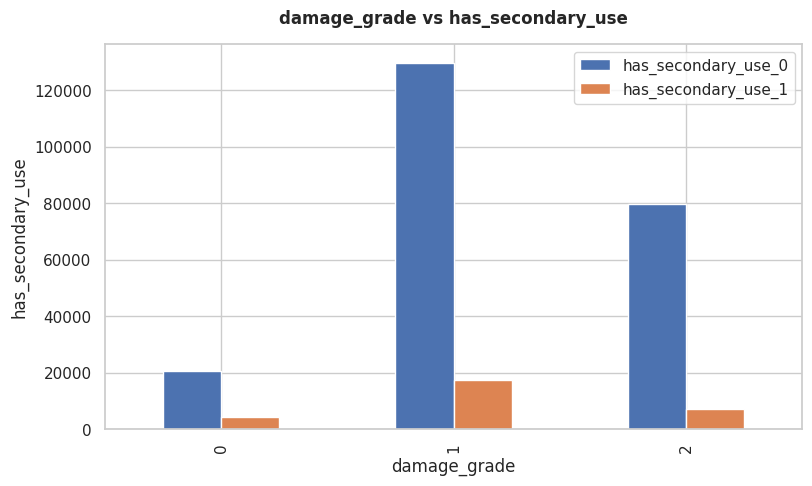

In [489]:
earthq_has_secondary_use.loc[:,['has_secondary_use_0','has_secondary_use_1']].plot(kind="bar")
plt.title("damage_grade vs has_secondary_use", pad=15, fontweight='bold')
plt.xlabel("damage_grade")
plt.ylabel("has_secondary_use")

In [490]:
has_secondary_use = earthquakes2.loc[earthquakes2['has_secondary_use'] == 1 ,['has_secondary_use']].count()
not_has_secondary_use = earthquakes2.loc[earthquakes2['has_secondary_use'] == 0 ,['has_secondary_use']].count()
total = has_secondary_use + not_has_secondary_use

has_secondary_use_perc = round(((has_secondary_use * 100)/total)[0],2)
not_has_secondary_use_perc = round(((not_has_secondary_use * 100)/total)[0],2)

print('has_secondary_use_perc = ' + str(has_secondary_use_perc) + '%')
print('not_has_secondary_use_perc = ' + str(not_has_secondary_use_perc) + '%')

has_secondary_use_perc = 11.17%
not_has_secondary_use_perc = 88.83%


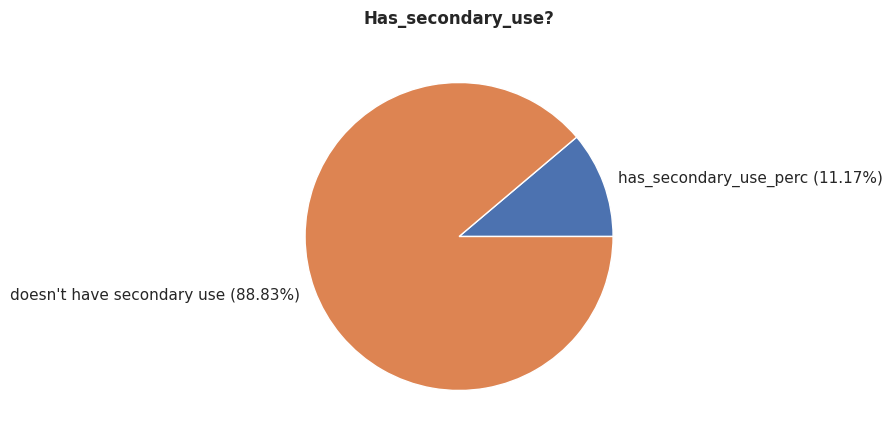

In [491]:
percentage_secondary_use = np.array([has_secondary_use_perc, not_has_secondary_use_perc])
labels = ["has_secondary_use_perc (" + str(has_secondary_use_perc) + "%)", \
          "doesn't have secondary use (" + str(not_has_secondary_use_perc) + "%)"]

plt.pie(percentage_secondary_use, labels = labels)
plt.title("Has_secondary_use?", pad='15.0', fontweight='bold')
plt.show() 

Text(77.54687499999999, 0.5, 'has_superstructure')

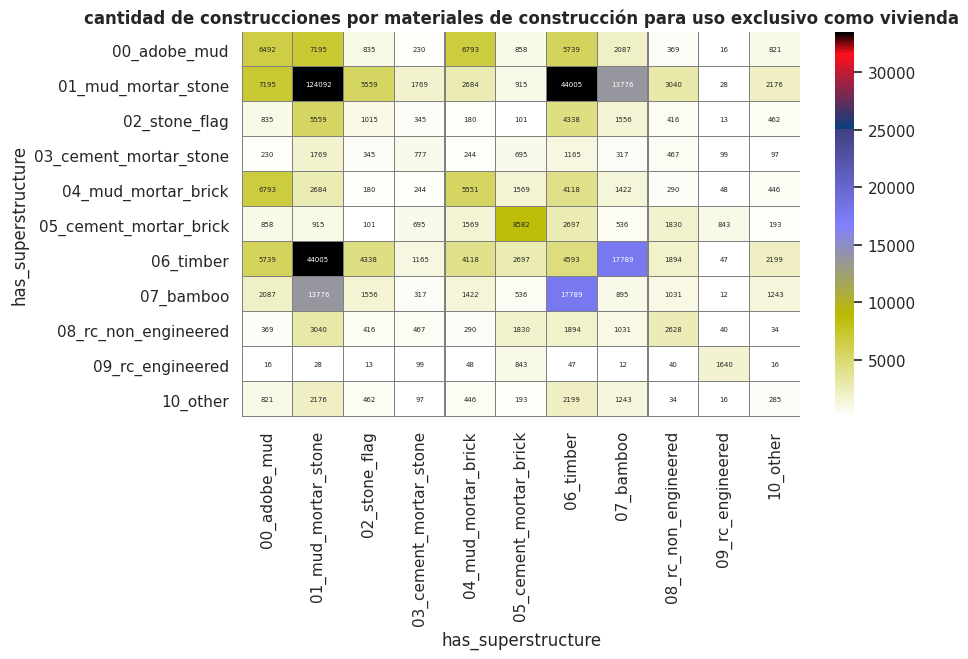

In [492]:
# Realizamos nuevamente el análisis por heatmaps de cantidades y de promedios,
# para los dos subsets de datos del gráfico anterior

# primero se generara el filtro para los heatmap con los que no tienen uso secundario
# se generará un subdataframe solo con los campos boolean de MATERIALES CONSTRUCTIVOS
# se renombraran las columnas con un prefijo para que no lo ordene alfabeticamente

filtroheatmaps=earthquakes['has_secondary_use']==0
boolmaterials=earthquakes[filtroheatmaps].iloc[:,[12,13,14,15,16,17,18,19,20,21,22]]
boolmaterials.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                       '03_cement_mortar_stone','04_mud_mortar_brick',\
                       '05_cement_mortar_brick','06_timber','07_bamboo',\
                       '08_rc_non_engineered','09_rc_engineered','10_other']

# antes de agregarle un campo, se genera una serie con la cantidad de True por cada row
# y filtrando los registros con un solo True, se cuentan los mismos por cada campo
# esto será usado para completar la diagonal del heatmap
# luego se agrega un campo "contador" para sumar registros

seriediagonal=boolmaterials[boolmaterials[boolmaterials==True].count(axis=1)==1].sum()
boolmaterials['contador']=1

# se itera entre los 11 campos boolean, para generar por cada uno,
# un pivot_table con la suma de cada match entre dicho campo y los otros 10

for i in range(11):
  filtro_p=boolmaterials[boolmaterials.columns.get_level_values(0)[i]]==True
  prueba_bool_concat=boolmaterials[filtro_p].\
                      pivot_table(index=boolmaterials.columns.\
                      get_level_values(0)[i],columns=['contador'],aggfunc=np.sum)
  if i==0:
    matrizfor=prueba_bool_concat
  else:
    matrizfor=pd.concat([matrizfor,prueba_bool_concat])

# se limpian los indices y columnas

matrizfor.columns=matrizfor.columns.get_level_values(0)
matrizfor.reset_index(inplace=True)
matrizfor.drop(columns='index',inplace=True)

# se reemplazan los valores del indice, por los nombres de cada row,
# correspondientes a la columna que representan
# se agregan los datos de la seriediagonal en reemplazo de los valores "nan"

matrizfor['nombres']='abc'
for i in range(11):
  matrizfor['nombres'][i]=matrizfor.columns.get_level_values(0)[i]
  matrizfor[matrizfor.columns.get_level_values(0)[i]][i]=\
  seriediagonal[seriediagonal.index==matrizfor.columns.get_level_values(0)[i]]
matrizfor.set_index('nombres',drop=True, inplace=True)

#por último se genera el heatmap

g = sns.heatmap(matrizfor,linewidths=.1,annot=True,annot_kws={"size": 5},\
                cmap="gist_stern_r",fmt='g',robust=True,linecolor='gray')
g.set_title("cantidad de construcciones por materiales de construcción para uso exclusivo como vivienda",fontsize=12, fontweight='bold')
g.set_xlabel("has_superstructure")
g.set_ylabel("has_superstructure")

Text(77.54687499999999, 0.5, 'has_superstructure')

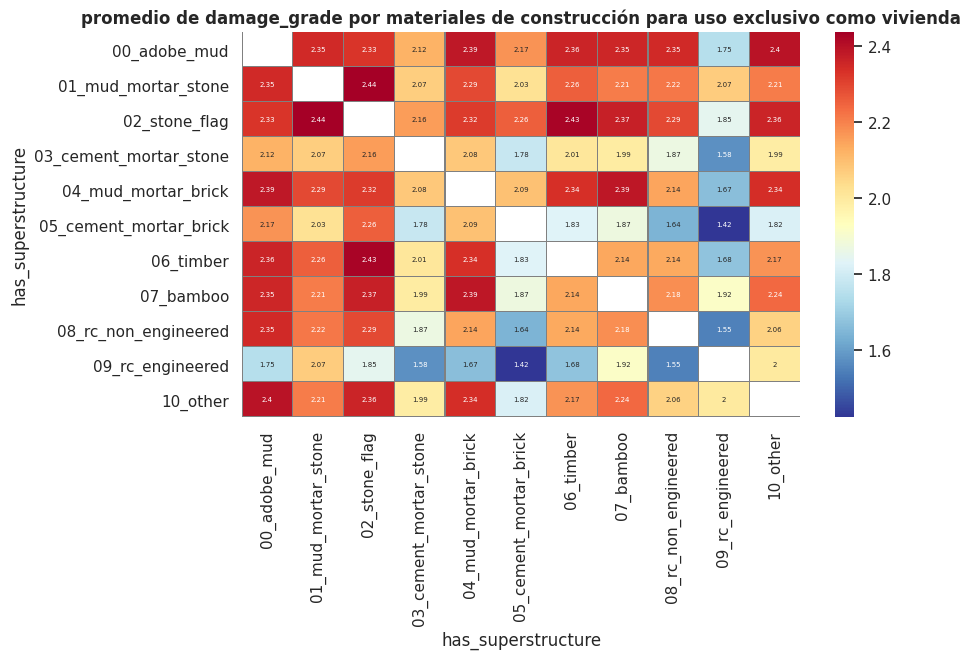

In [493]:
# se comienza de nuevo para un heatmap de medias de damage
# para esto se usa el filtro anterior, dado que los totales para el promedio
# seran utilizados a partir de la "matrizfor" generada anteriormente

boolmaterials_damage=earthquakes[filtroheatmaps].iloc[:,[12,13,14,15,16,17,18,19,20,21,22,36]]
boolmaterials_damage.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                              '03_cement_mortar_stone','04_mud_mortar_brick',\
                              '05_cement_mortar_brick','06_timber','07_bamboo',\
                              '08_rc_non_engineered','09_rc_engineered','10_other','damage_grade']
for i in range(11):
  boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]=\
  boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]*\
  boolmaterials_damage['damage_grade']
boolmaterials_damage.drop(columns='damage_grade',inplace=True)

for i in range(11):
  filtro_p=boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]>0
  bool_merge=boolmaterials_damage[filtro_p].\
                      pivot_table(index=boolmaterials_damage.columns.\
                      get_level_values(0)[i],aggfunc={np.sum})
  bool_merge.columns=bool_merge.columns.get_level_values(0)
  serie_bool=bool_merge.sum()/matrizfor.loc[:,boolmaterials_damage.columns.get_level_values(0)[i]]
  if i==0:
    matriz_mean0=serie_bool
  else:
    matriz_mean0=pd.concat([matriz_mean0,serie_bool],axis=1)
matriz_mean0.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                              '03_cement_mortar_stone','04_mud_mortar_brick',\
                              '05_cement_mortar_brick','06_timber','07_bamboo',\
                              '08_rc_non_engineered','09_rc_engineered','10_other']

#por último se genera el heatmap de promedios

g = sns.heatmap(matriz_mean0,linewidths=.1,annot=True,annot_kws={"size": 5},\
                cmap="RdYlBu_r",fmt='.3g',robust=False,linecolor='gray')
g.set_title("promedio de damage_grade por materiales de construcción para uso exclusivo como vivienda",fontsize=12, fontweight='bold')
g.set_xlabel("has_superstructure")
g.set_ylabel("has_superstructure")

Text(77.54687499999999, 0.5, 'has_superstructure')

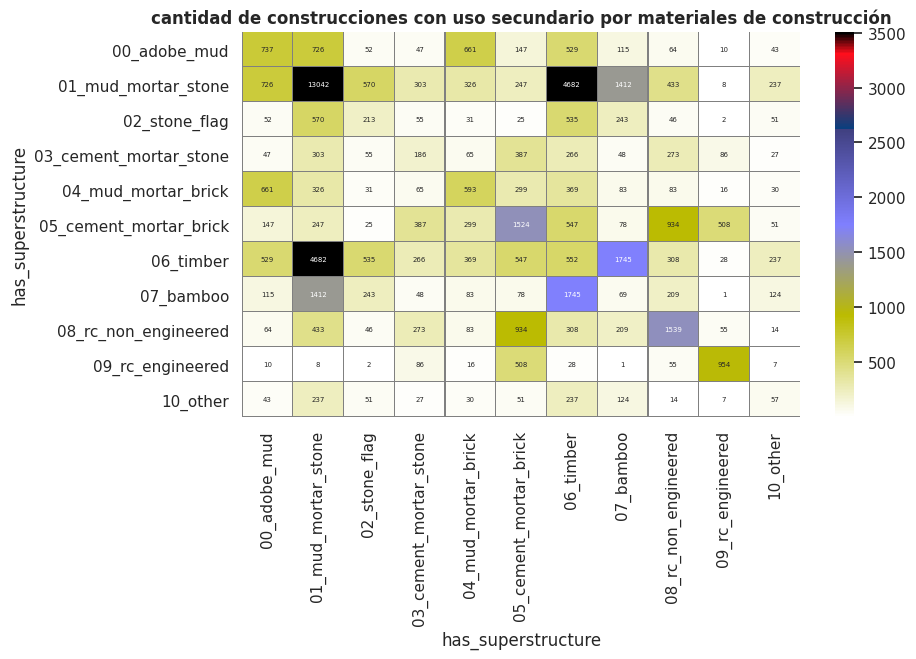

In [494]:
# Realizamos nuevamente el análisis por heatmaps de cantidades y de promedios,
# para los dos subsets de datos del gráfico anterior

# primero se generara el filtro para los heatmap con los que tienen uso secundario
# se generará un subdataframe solo con los campos boolean de MATERIALES CONSTRUCTIVOS
# se renombraran las columnas con un prefijo para que no lo ordene alfabeticamente

filtroheatmaps=earthquakes['has_secondary_use']==1
boolmaterials=earthquakes[filtroheatmaps].iloc[:,[12,13,14,15,16,17,18,19,20,21,22]]
boolmaterials.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                       '03_cement_mortar_stone','04_mud_mortar_brick',\
                       '05_cement_mortar_brick','06_timber','07_bamboo',\
                       '08_rc_non_engineered','09_rc_engineered','10_other']

# antes de agregarle un campo, se genera una serie con la cantidad de True por cada row
# y filtrando los registros con un solo True, se cuentan los mismos por cada campo
# esto será usado para completar la diagonal del heatmap
# luego se agrega un campo "contador" para sumar registros

seriediagonal=boolmaterials[boolmaterials[boolmaterials==True].count(axis=1)==1].sum()
boolmaterials['contador']=1

# se itera entre los 11 campos boolean, para generar por cada uno,
# un pivot_table con la suma de cada match entre dicho campo y los otros 10

for i in range(11):
  filtro_p=boolmaterials[boolmaterials.columns.get_level_values(0)[i]]==True
  prueba_bool_concat=boolmaterials[filtro_p].\
                      pivot_table(index=boolmaterials.columns.\
                      get_level_values(0)[i],columns=['contador'],aggfunc=np.sum)
  if i==0:
    matrizfor=prueba_bool_concat
  else:
    matrizfor=pd.concat([matrizfor,prueba_bool_concat])

# se limpian los indices y columnas

matrizfor.columns=matrizfor.columns.get_level_values(0)
matrizfor.reset_index(inplace=True)
matrizfor.drop(columns='index',inplace=True)

# se reemplazan los valores del indice, por los nombres de cada row,
# correspondientes a la columna que representan
# se agregan los datos de la seriediagonal en reemplazo de los valores "nan"

matrizfor['nombres']='abc'
for i in range(11):
  matrizfor['nombres'][i]=matrizfor.columns.get_level_values(0)[i]
  matrizfor[matrizfor.columns.get_level_values(0)[i]][i]=\
  seriediagonal[seriediagonal.index==matrizfor.columns.get_level_values(0)[i]]
matrizfor.set_index('nombres',drop=True, inplace=True)

#por último se genera el heatmap

g = sns.heatmap(matrizfor,linewidths=.1,annot=True,annot_kws={"size": 5},\
                cmap="gist_stern_r",fmt='g',robust=True,linecolor='gray')
g.set_title("cantidad de construcciones con uso secundario por materiales de construcción",fontsize=12, fontweight='bold')
g.set_xlabel("has_superstructure")
g.set_ylabel("has_superstructure")

Text(77.54687499999999, 0.5, 'has_superstructure')

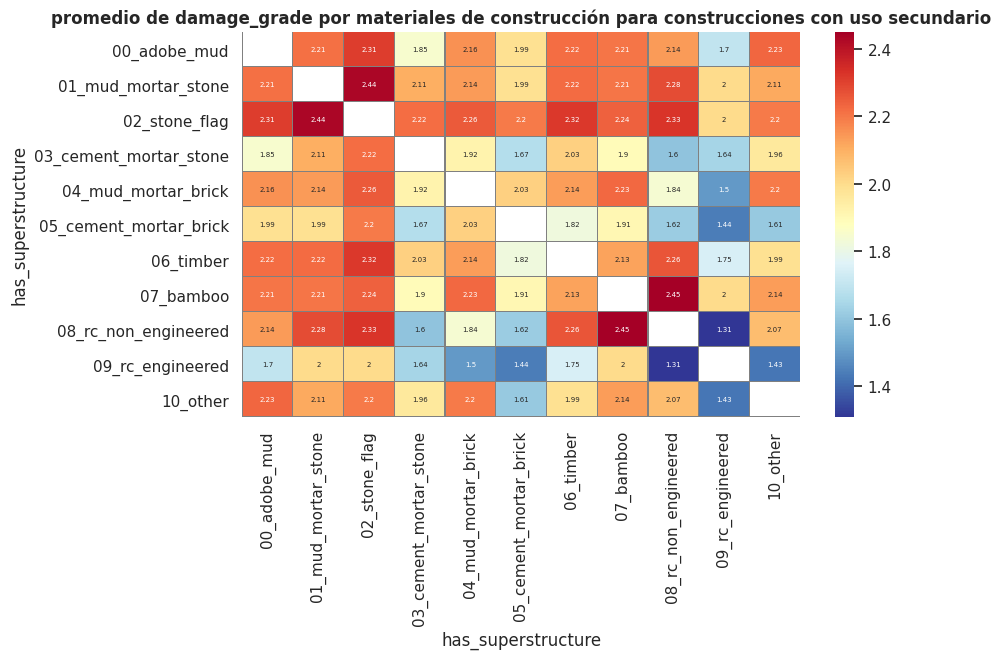

In [495]:
# se comienza de nuevo para un heatmap de medias de damage
# para esto se usa el filtro anterior, dado que los totales para el promedio
# seran utilizados a partir de la "matrizfor" generada anteriormente

boolmaterials_damage=earthquakes[filtroheatmaps].iloc[:,[12,13,14,15,16,17,18,19,20,21,22,36]]
boolmaterials_damage.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                              '03_cement_mortar_stone','04_mud_mortar_brick',\
                              '05_cement_mortar_brick','06_timber','07_bamboo',\
                              '08_rc_non_engineered','09_rc_engineered','10_other','damage_grade']
for i in range(11):
  boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]=\
  boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]*\
  boolmaterials_damage['damage_grade']
boolmaterials_damage.drop(columns='damage_grade',inplace=True)

for i in range(11):
  filtro_p=boolmaterials_damage[boolmaterials_damage.columns.get_level_values(0)[i]]>0
  bool_merge=boolmaterials_damage[filtro_p].\
                      pivot_table(index=boolmaterials_damage.columns.\
                      get_level_values(0)[i],aggfunc={np.sum})
  bool_merge.columns=bool_merge.columns.get_level_values(0)
  serie_bool=bool_merge.sum()/matrizfor.loc[:,boolmaterials_damage.columns.get_level_values(0)[i]]
  if i==0:
    matriz_mean1=serie_bool
  else:
    matriz_mean1=pd.concat([matriz_mean1,serie_bool],axis=1)
matriz_mean1.columns=['00_adobe_mud','01_mud_mortar_stone','02_stone_flag',\
                              '03_cement_mortar_stone','04_mud_mortar_brick',\
                              '05_cement_mortar_brick','06_timber','07_bamboo',\
                              '08_rc_non_engineered','09_rc_engineered','10_other']

#por último se genera el heatmap de promedios

g = sns.heatmap(matriz_mean1,linewidths=.1,annot=True,annot_kws={"size": 5},\
                cmap="RdYlBu_r",fmt='.3g',robust=False,linecolor='gray')
g.set_title("promedio de damage_grade por materiales de construcción para construcciones con uso secundario",fontsize=12, fontweight='bold')
g.set_xlabel("has_superstructure")
g.set_ylabel("has_superstructure")

Text(77.54687499999999, 0.5, 'has_superstructure')

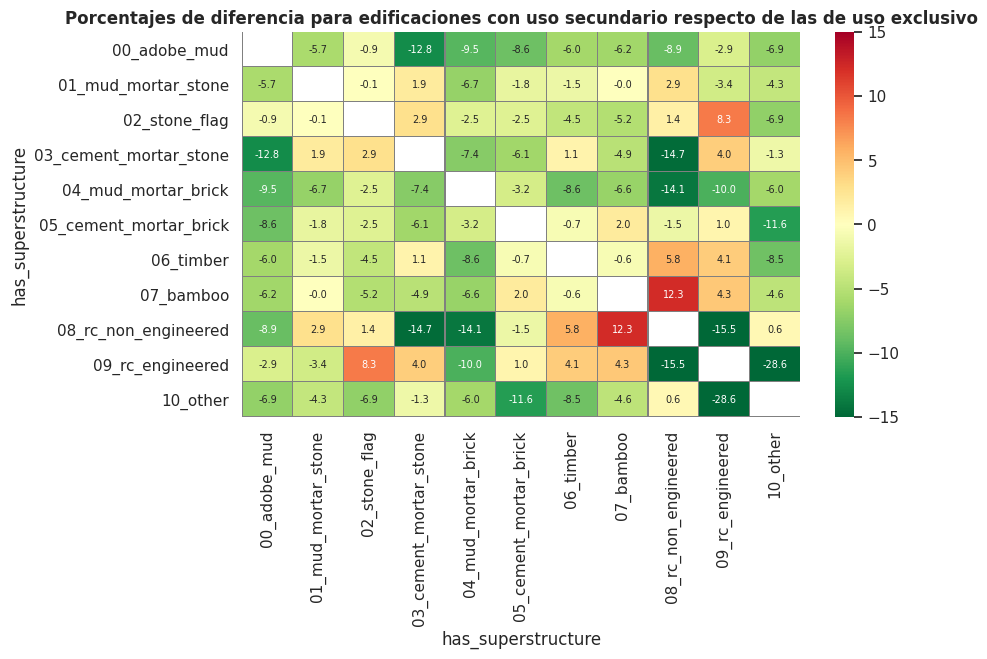

In [496]:
# ahora teniendo dos matrices de promedios de grado de daño,
# una para los correspondientes a edificaciones como vivienda exclusivamente
# y otra correspondiente a edificaciones con uso secundario
# las dividimos entre si para calcular porcentajes de una respecto de la otra

matriz_mean_dif=(matriz_mean1/matriz_mean0-1)*100

# y procedemos a hacer un heatmap del resultado

g = sns.heatmap(matriz_mean_dif,linewidths=.1,annot=True,annot_kws={"size": 7},\
                cmap="RdYlGn_r",fmt='.1f',robust=False,linecolor='gray',vmin=-15,vmax=15)
g.set_title("Porcentajes de diferencia para edificaciones con uso secundario respecto de las de uso exclusivo",fontsize=12, fontweight='bold')
g.set_xlabel("has_superstructure")
g.set_ylabel("has_superstructure")

In [497]:
earthquakes_by_other_uses = earthquakes2.loc[earthquakes2['has_secondary_use'] == 1]

earthquakes_by_other_uses = earthquakes_by_other_uses.loc[:,['has_secondary_use_agriculture', \
                                                'has_secondary_use_hotel', \
                                                'has_secondary_use_rental', \
                                                'has_secondary_use_institution',\
                                                'has_secondary_use_school', \
                                                'has_secondary_use_industry', \
                                                'has_secondary_use_health_post', \
                                                'has_secondary_use_gov_office', \
                                                'has_secondary_use_use_police', \
                                                'has_secondary_use_other', \
                                                'damage_grade']]
earthquakes_by_other_uses

has_secondary_use_agriculture  ...  damage_grade
5                                True  ...             2
20                               True  ...             2
26                               True  ...             2
45                              False  ...             1
57                               True  ...             2
...                               ...  ...           ...
260567                           True  ...             1
260584                           True  ...             3
260587                           True  ...             3
260591                           True  ...             3
260593                           True  ...             2

[28951 rows x 11 columns]

In [498]:
# 
has_secondary_use_agriculture = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_agriculture'] == 1]['has_secondary_use_agriculture'].count()
has_secondary_use_hotel  = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_hotel'] == 1]['has_secondary_use_hotel'].count()
has_secondary_use_rental = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_rental'] == 1]['has_secondary_use_rental'].count()
has_secondary_use_institution = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_institution'] == 1]['has_secondary_use_institution'].count()
has_secondary_use_school = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_school'] == 1]['has_secondary_use_school'].count()
has_secondary_use_industry = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_industry'] == 1]['has_secondary_use_industry'].count()
has_secondary_use_health_post = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_health_post'] == 1]['has_secondary_use_health_post'].count()
has_secondary_use_gov_office = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_gov_office'] == 1]['has_secondary_use_gov_office'].count()
has_secondary_use_use_police = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_use_police'] == 1]['has_secondary_use_use_police'].count()
has_secondary_use_other = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_other'] == 1]['has_secondary_use_other'].count()

has_secondary_use_agriculture_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_agriculture'] == 1]['damage_grade'].mean()
has_secondary_use_hotel_mean  = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_hotel'] == 1]['damage_grade'].mean()
has_secondary_use_rental_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_rental'] == 1]['damage_grade'].mean()
has_secondary_use_institution_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_institution'] == 1]['damage_grade'].mean()
has_secondary_use_school_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_school'] == 1]['damage_grade'].mean()
has_secondary_use_industry_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_industry'] == 1]['damage_grade'].mean()
has_secondary_use_health_post_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_health_post'] == 1]['damage_grade'].mean()
has_secondary_use_gov_office_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_gov_office'] == 1]['damage_grade'].mean()
has_secondary_use_use_police_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_use_police'] == 1]['damage_grade'].mean()
has_secondary_use_other_mean = earthquakes_by_other_uses.loc[earthquakes_by_other_uses['has_secondary_use_other'] == 1]['damage_grade'].mean()

uses = ['has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
counts = [has_secondary_use_agriculture, has_secondary_use_hotel, has_secondary_use_rental, has_secondary_use_institution, has_secondary_use_school, has_secondary_use_industry, has_secondary_use_health_post, has_secondary_use_gov_office, has_secondary_use_use_police, has_secondary_use_other]
means = [has_secondary_use_agriculture_mean, has_secondary_use_hotel_mean, has_secondary_use_rental_mean, has_secondary_use_institution_mean, has_secondary_use_school_mean, has_secondary_use_industry_mean, has_secondary_use_health_post_mean, has_secondary_use_gov_office_mean, has_secondary_use_use_police_mean, has_secondary_use_other_mean]
has_secondary_use_quantities = {'use': uses, 'count': counts, 'mean_damage_grade': means}
has_secondary_use_quantities = pd.DataFrame(data=has_secondary_use_quantities)
has_secondary_use_quantities

use  count    mean_damage_grade
0  has_secondary_use_agriculture  16654                 2.26
1        has_secondary_use_hotel   8709                 1.92
2       has_secondary_use_rental   2087                 1.67
3  has_secondary_use_institution    244                 1.67
4       has_secondary_use_school     94                 1.86
5     has_secondary_use_industry    279                 2.03
6  has_secondary_use_health_post     49                 1.86
7   has_secondary_use_gov_office     38                 1.76
8   has_secondary_use_use_police     23                 2.13
9        has_secondary_use_other   1331                 2.10

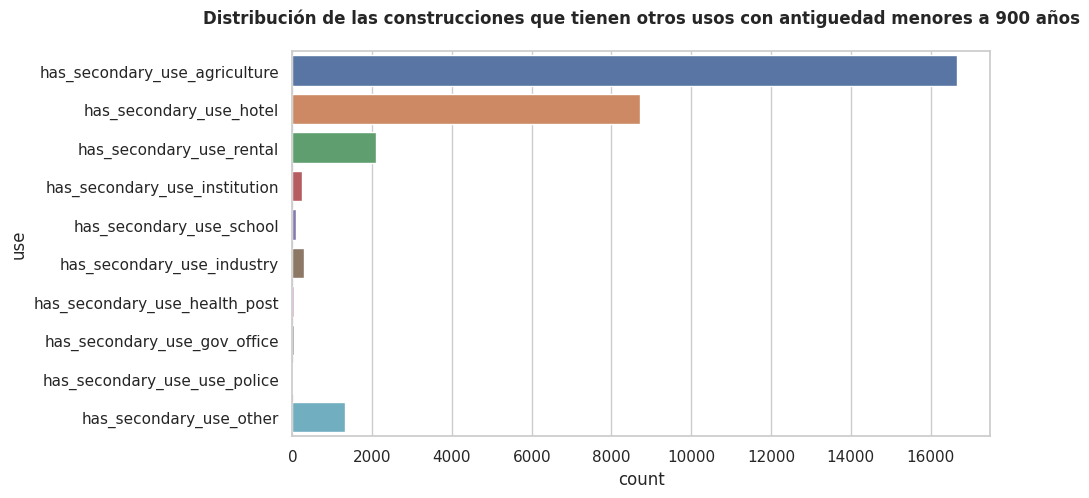

In [499]:
ax = sns.barplot(x='count', y='use', data=has_secondary_use_quantities).set_title("Distribución de las construcciones que tienen otros usos con antiguedad menores a 900 años", fontsize=12, fontweight='bold', y=1.05)

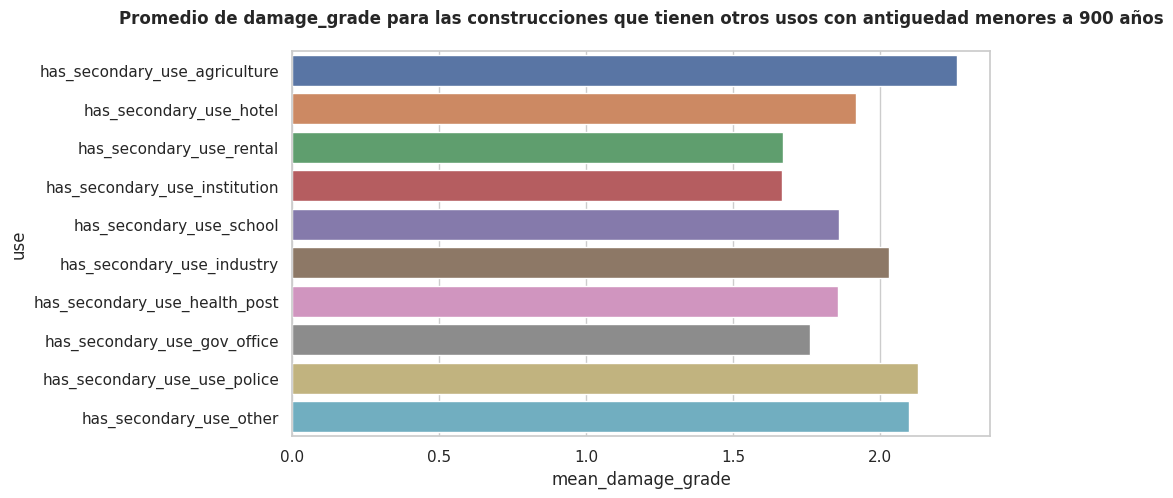

In [500]:
ax = sns.barplot(x='mean_damage_grade', y='use', data=has_secondary_use_quantities).set_title("Promedio de damage_grade para las construcciones que tienen otros usos con antiguedad menores a 900 años", fontsize=12, fontweight='bold', y=1.05)

In [501]:
#solo analizando los que tienen mas de 900 años de antiguedad 
earthquakes_by_other_uses_900 = earthquakes.loc[earthquakes['age'] >= 900]
earthquakes_by_other_uses_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use'] == 1]

earthquakes_by_other_uses_900 = earthquakes_by_other_uses_900.loc[:,['has_secondary_use_agriculture','has_secondary_use_hotel', 'has_secondary_use_rental', \
                                                                   'has_secondary_use_institution','has_secondary_use_school', 'has_secondary_use_industry', \
                                                                    'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', \
                                                                    'has_secondary_use_other', 'damage_grade']]

has_secondary_use_agriculture_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_agriculture'] == 1]['has_secondary_use_agriculture'].count()
has_secondary_use_hotel_900  = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_hotel'] == 1]['has_secondary_use_hotel'].count()
has_secondary_use_rental_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_rental'] == 1]['has_secondary_use_rental'].count()
has_secondary_use_institution_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_institution'] == 1]['has_secondary_use_institution'].count()
has_secondary_use_school_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_school'] == 1]['has_secondary_use_school'].count()
has_secondary_use_industry_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_industry'] == 1]['has_secondary_use_industry'].count()
has_secondary_use_health_post_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_health_post'] == 1]['has_secondary_use_health_post'].count()
has_secondary_use_gov_office_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_gov_office'] == 1]['has_secondary_use_gov_office'].count()
has_secondary_use_use_police_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_use_police'] == 1]['has_secondary_use_use_police'].count()
has_secondary_use_other_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_other'] == 1]['has_secondary_use_other'].count()

has_secondary_use_agriculture_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_agriculture'] == 1]['damage_grade'].mean()
has_secondary_use_hotel_mean_900  = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_hotel'] == 1]['damage_grade'].mean()
has_secondary_use_rental_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_rental'] == 1]['damage_grade'].mean()
has_secondary_use_institution_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_institution'] == 1]['damage_grade'].mean()
has_secondary_use_school_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_school'] == 1]['damage_grade'].mean()
has_secondary_use_industry_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_industry'] == 1]['damage_grade'].mean()
has_secondary_use_health_post_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_health_post'] == 1]['damage_grade'].mean()
has_secondary_use_gov_office_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_gov_office'] == 1]['damage_grade'].mean()
has_secondary_use_use_police_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_use_police'] == 1]['damage_grade'].mean()
has_secondary_use_other_mean_900 = earthquakes_by_other_uses_900.loc[earthquakes_by_other_uses_900['has_secondary_use_other'] == 1]['damage_grade'].mean()

uses_900 = ['has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
counts_900 = [has_secondary_use_agriculture_900, has_secondary_use_hotel_900, has_secondary_use_rental_900, has_secondary_use_institution_900, has_secondary_use_school_900, has_secondary_use_industry_900, has_secondary_use_health_post_900, has_secondary_use_gov_office_900, has_secondary_use_use_police_900, has_secondary_use_other_900]
means_900 = [has_secondary_use_agriculture_mean_900, has_secondary_use_hotel_mean_900, has_secondary_use_rental_mean_900, has_secondary_use_institution_mean_900, has_secondary_use_school_mean_900, has_secondary_use_industry_mean_900, has_secondary_use_health_post_mean_900, has_secondary_use_gov_office_mean_900, has_secondary_use_use_police_mean_900, has_secondary_use_other_mean_900]
has_secondary_use_quantities_900 = {'use': uses_900, 'count': counts_900, 'mean_damage_grade': means_900}
has_secondary_use_quantities_900 = pd.DataFrame(data=has_secondary_use_quantities_900)
has_secondary_use_quantities_900

use  count    mean_damage_grade
0  has_secondary_use_agriculture     73                 2.47
1        has_secondary_use_hotel     53                 1.79
2       has_secondary_use_rental     24                 1.88
3  has_secondary_use_institution      1                 1.00
4       has_secondary_use_school      0                  nan
5     has_secondary_use_industry      0                  nan
6  has_secondary_use_health_post      0                  nan
7   has_secondary_use_gov_office      0                  nan
8   has_secondary_use_use_police      0                  nan
9        has_secondary_use_other      3                 1.67

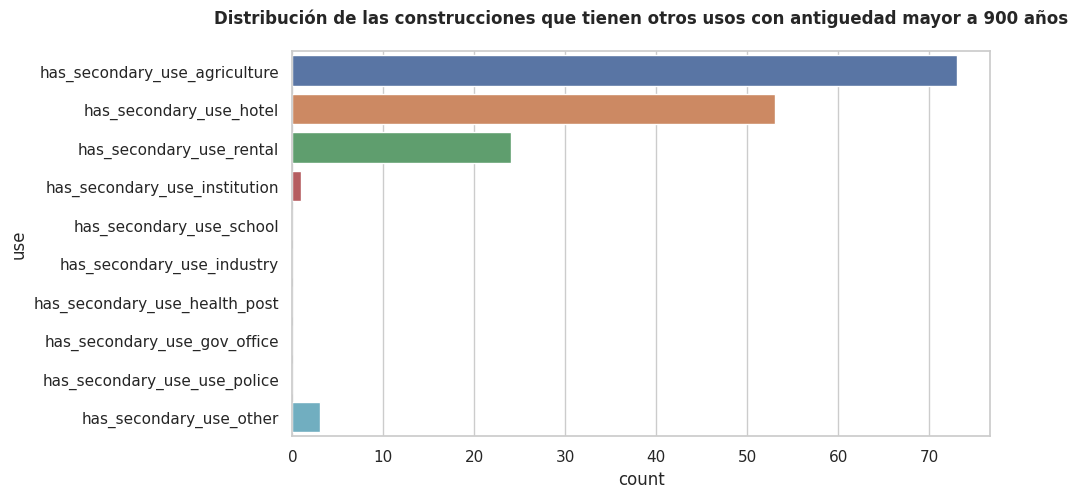

In [502]:
ax = sns.barplot(x='count', y='use', data=has_secondary_use_quantities_900).set_title("Distribución de las construcciones que tienen otros usos con antiguedad mayor a 900 años", fontsize=12, fontweight='bold', y=1.05)

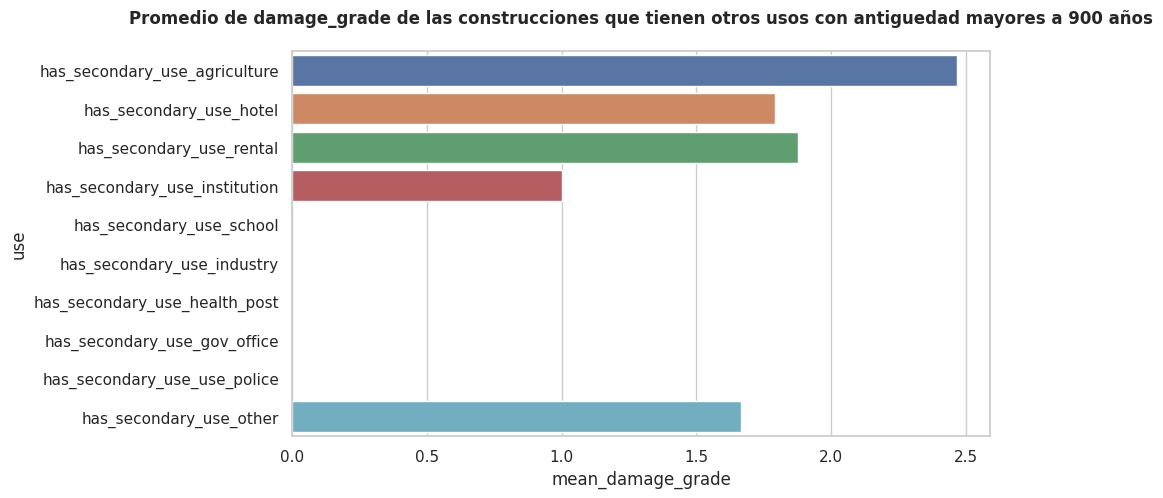

In [503]:
ax = sns.barplot(x='mean_damage_grade', y='use', data=has_secondary_use_quantities_900).set_title("Promedio de damage_grade de las construcciones que tienen otros usos con antiguedad mayores a 900 años", fontsize=12, fontweight='bold', y=1.05)